<a href="https://colab.research.google.com/github/MilerDiazZevallos/Arequipa-Covid-19/blob/master/Sala_Situacional_Arequipa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initialize Environment

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from scipy.optimize import curve_fit

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import auth
auth.authenticate_user()

import gspread
from oauth2client.client import GoogleCredentials

gc = gspread.authorize(GoogleCredentials.get_application_default())

# R Function
### Reference:
### https://github.com/k-sys/covid-19/blob/master/Realtime%20R0.ipynb

In [68]:
#@title
# general imports
import numpy as np
import datetime as dt

from joblib import Parallel, delayed

# matplotlib
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

# scipy specifics
from scipy import stats as sps
from scipy.interpolate import interp1d

# We create an array for every possible value of Rt
R_T_MAX = 12
r_t_range = np.linspace(0, R_T_MAX, R_T_MAX*100+1)
#print(len(r_t_range))
# best sigma for Perú (prior hyperparameters)
#OPTIMAL_SIGMA = 0.35 # through Kevin's Optimization
OPTIMAL_SIGMA = 0.01

# Gamma is 1/serial interval
# https://wwwnc.cdc.gov/eid/article/26/7/20-0282_article
# https://www.nejm.org/doi/full/10.1056/NEJMoa2001316
GAMMA = 1/7

#@title
def smooth_new_cases(new_cases):
    
    """
    Function to apply gaussian smoothing to cases
    Arguments
    ----------
    new_cases: time series of new cases
    Returns 
    ----------
    smoothed_cases: cases after gaussian smoothing
    See also
    ----------
    This code is heavily based on Realtime R0
    by Kevin Systrom
    https://github.com/k-sys/covid-19/blob/master/Realtime%20R0.ipynb
    """

    smoothed_cases = new_cases.rolling(7,
        win_type='gaussian',
        min_periods=1,
        center=True).mean(std=2).round()

    #print(smoothed_cases.to_csv('smoothed_cases'))

    
    zeros = smoothed_cases.index[smoothed_cases.eq(0)]
    #print(len(zeros))
    
    if len(zeros) == 0:
        idx_start = 0
    else:
        last_zero = zeros.max()
        idx_start = smoothed_cases.index.get_loc(last_zero) + 1
        #print(last_zero)
        #print(idx_start)

    
    smoothed_cases = smoothed_cases.iloc[idx_start:]
    original = new_cases.loc[smoothed_cases.index]
    
    #print(smoothed_cases.head())
    #print(original.head())

    #print('End smoothed')
    return original, smoothed_cases
    

def calculate_posteriors(sr, sigma=0.15):

    """
    Function to calculate posteriors of Rt over time
    Arguments
    ----------
    sr: smoothed time series of new cases
    sigma: gaussian noise applied to prior so we can "forget" past observations
           works like exponential weighting
    Returns 
    ----------
    posteriors: posterior distributions
    log_likelihood: log likelihood given data
    See also
    ----------
    This code is heavily based on Realtime R0
    by Kevin Systrom
    https://github.com/k-sys/covid-19/blob/master/Realtime%20R0.ipynb
    """

    # (1) Calculate Lambda
    #print(sr[:-1].tail())
    lam = sr[:-1].values * np.exp(GAMMA * (r_t_range[:, None] - 1))
    #print('lam shape', lam.shape)
    
    
    # (2) Calculate each day's likelihood
    likelihoods = pd.DataFrame(
        data = sps.poisson.pmf(sr[1:].values, lam),
        index = r_t_range,
        columns = sr.index[1:])
    #print('likelihoods shape', likelihoods.shape)

    
    # (3) Create the Gaussian Matrix
    process_matrix = sps.norm(loc=r_t_range,
                              scale=sigma
                             ).pdf(r_t_range[:, None]) 
    #print('process_matrix shape', process_matrix.shape)

    # (3a) Normalize all rows to sum to 1
    process_matrix /= process_matrix.sum(axis=0)
    #print('process_matrix shape', process_matrix.shape)
    
    # (4) Calculate the initial prior
    prior0 = sps.gamma(a=4).pdf(r_t_range)
    prior0 /= prior0.sum()
    #print('prior0 shape', prior0.shape)

    # Create a DataFrame that will hold our posteriors for each day
    # Insert our prior as the first posterior.
    posteriors = pd.DataFrame(
        index=r_t_range,
        columns=sr.index,
        data={sr.index[0]: prior0}
    )
    #print('posteriors shape', posteriors.shape)
    
    # We said we'd keep track of the sum of the log of the probability
    # of the data for maximum likelihood calculation.
    log_likelihood = 0.0

    #print(sr.index[:-1])
    #print(sr.index[1:])
    
    # (5) Iteratively apply Bayes' rule
    for previous_day, current_day in zip(sr.index[:-1], sr.index[1:]):

        #(5a) Calculate the new prior
        current_prior = process_matrix @ posteriors[previous_day]
        
        #(5b) Calculate the numerator of Bayes' Rule: P(k|R_t)P(R_t)
        numerator = likelihoods[current_day] * current_prior
        
        #(5c) Calcluate the denominator of Bayes' Rule P(k)
        denominator = np.sum(numerator)
        
        # Execute full Bayes' Rule
        posteriors[current_day] = numerator/denominator
        
        # Add to the running sum of log likelihoods
        log_likelihood += np.log(denominator)
    
    return posteriors, log_likelihood
    

def highest_density_interval(pmf, p=.9):

    """
    Function to calculate highest density interval 
    from posteriors of Rt over time
    Arguments
    ----------
    pmf: posterior distribution of Rt
    p: mass of high density interval
    Returns 
    ----------
    interval: expected value and density interval
    See also
    ----------
    This code is heavily based on Realtime R0
    by Kevin Systrom
    https://github.com/k-sys/covid-19/blob/master/Realtime%20R0.ipynb
    """

    # If we pass a DataFrame, just call this recursively on the columns
    if(isinstance(pmf, pd.DataFrame)):
        return pd.DataFrame([highest_density_interval(pmf[col], p=p) for col in pmf],
                            index=pmf.columns)
    
    cumsum = np.cumsum(pmf.values)
    #print(cumsum.shape)
    
    best = None
    for i, value in enumerate(cumsum):
        for j, high_value in enumerate(cumsum[i+1:]):
            if (high_value-value > p) and (not best or j<best[1]-best[0]):
                best = (i, i+j+1)
                break
            
    low = pmf.index[best[0]]
    high = pmf.index[best[1]]
    most_likely = pmf.idxmax()

    interval = pd.Series([most_likely, low, high], index=['ML',f'Low_{p*100:.0f}', f'High_{p*100:.0f}'])

    return interval
    

def plot_rt(result, ax, state_name):
    
    """
    Function to plot Rt
    Arguments
    ----------
    result: expected value and HDI of posterior
    ax: matplotlib axes 
    state_name: state to be considered
    See also
    ----------
    This code is heavily based on Realtime R0
    by Kevin Systrom
    https://github.com/k-sys/covid-19/blob/master/Realtime%20R0.ipynb
    """

    ax.set_title(f"{state_name}")

    # Colors
    ABOVE = [1,0,0]
    MIDDLE = [1,1,1]
    BELOW = [0,0,0]
    cmap = ListedColormap(np.r_[
        np.linspace(BELOW,MIDDLE,25),
        np.linspace(MIDDLE,ABOVE,25)
    ])
    color_mapped = lambda y: np.clip(y, .5, 1.5)-.5
    
    index = result['ML'].index.get_level_values('date')
    values = result['ML'].values
    
    # Plot dots and line
    #ax.plot(index, values, c='k', zorder=1, alpha=.25)
    ax.scatter(index, values, s=40, lw=.5, c=cmap(color_mapped(values)), edgecolors='k', zorder=2)
    
    # Aesthetically, extrapolate credible interval by 1 day either side
    lowfn = interp1d(date2num(index), result['Low_90'].values, bounds_error=False, fill_value='extrapolate')
    
    highfn = interp1d(date2num(index), result['High_90'].values, bounds_error=False, fill_value='extrapolate')
    
    extended = pd.date_range(start=pd.Timestamp('2020-05-01'), end=index[-1]+pd.Timedelta(days=1))
    
    ax.fill_between(extended, lowfn(date2num(extended)), highfn(date2num(extended)), color='k', alpha=.1, lw=0, zorder=3)

    ax.axhline(1.0, c='k', lw=1, label='$R_t=1.0$', alpha=.25);
    
    # Formatting
    #ax.xaxis.set_major_locator(mdates.MonthLocator())
    #ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.yaxis.tick_right()
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.margins(0)
    ax.grid(which='major', axis='y', c='k', alpha=.25, zorder=-2)
    ax.margins(0)
    ax.set_ylim(0.0, 3.0)
    ax.set_xlim(pd.Timestamp('2020-05-01'), result.index.get_level_values('date')[-1]+pd.Timedelta(days=1))

    for i,j in zip(index,values):
        if i in mondays:
            ax.annotate(str(round(j, 2)),xy=(i,j+0.1), arrowprops=dict(facecolor='black', shrink=0.05),) 

def plot_standings(mr, figsize=None, title='Most Recent $R_t$ by State'):
    
    """
    Function to plot standings
    Arguments
    ----------
    mr: results by state
    See also
    ----------
    This code is heavily based on Realtime R0
    by Kevin Systrom
    https://github.com/k-sys/covid-19/blob/master/Realtime%20R0.ipynb
    """


    if not figsize:
        figsize = ((15.9/50)*len(mr)+.1,2.5)
        
    fig, ax = plt.subplots(figsize=figsize, dpi=150)

    ax.set_title(title)
    err = mr[['Low_90', 'High_90']].sub(mr['ML'], axis=0).abs()
    bars = ax.bar(mr.index,
                  mr['ML'],
                  width=.825,
                  color=[.7,.7,.7],
                  ecolor=[.3,.3,.3],
                  capsize=2,
                  error_kw={'alpha':.5, 'lw':1},
                  yerr=err.values.T)


    labels = mr.index.to_series().replace({'District of Columbia':'DC'})
    ax.set_xticklabels(labels, rotation=90, fontsize=11)
    ax.margins(0)
    ax.set_ylim(0,4.)
    ax.axhline(1.0, linestyle=':', color='k', lw=1)


    fig.set_facecolor('w')
    return fig, ax

def run_full_model(cases, sigma=OPTIMAL_SIGMA):
    # initializing result dict
    result = {''}

    # smoothing series
    new, smoothed = smooth_new_cases(cases)
    #smooth_new_cases(cases)

    # calculating posteriors
    posteriors, log_likelihood = calculate_posteriors(smoothed, sigma=sigma)
    #calculate_posteriors(smoothed, sigma=sigma)

    # calculating HDI
    result = highest_density_interval(posteriors, p=.9)
    #highest_density_interval(posteriors, p=.9)

    return result

# Doubling-time Function
### References:
### https://github.com/COVID-19-AI-Research-Project/AI-Data-Analysis/blob/master/Projects/1/Prediction_Covid_19_WorldWide.ipynb

###### A large doubling time is good.
###### A constant doubling time - means the measures being taken are effective in controlling the spread
###### An increasing doubling time means - the battle is on winning side
###### A decreasing doubling time-- well danger zone ahead. Do something fast

### https://www.npr.org/sections/health-shots/2020/04/10/829167659/are-we-flattening-the-curve-states-keep-watch-on-coronavirus-doubling-times

In [4]:
def prediction_country2(df1, tipo, plot=True):
    df_final = df1.copy()
    df_country = df_final
    df_country.reset_index(inplace=True)
    
    x=np.array(range(df_country.shape[0]))
    y=df_country[tipo].values
    #print(len(x))

    def func(x,a,b):
        return a*2**(x/b)

    def func1(x, a, b):
        return np.exp(b*(x-a))
  
  
    list_coeff = ['Arequipa']  
    for i in range(10, len(x)+1, 1):
        xdata = x[:i]
        ydata = y[:i]

        try:
            popt, pcov = curve_fit(func1,xdata=xdata,ydata=ydata)
        except:
            popt = np.array([0,0])
        
        #print(i, xdata, ydata, popt)
        popt_aux = popt[1]
        popt[1] = np.log(2.)/popt[1]
        list_coeff.append(popt)
  
    if plot:
        fig,(ax1) = plt.subplots(nrows=1,ncols=1,figsize=(16,8))

        #perc = np.diff(ydata) / ydata[:-1]
        #yfit = popt[0]*2**(xdata/popt[1])
        #perc_fit = np.diff(yfit) / yfit[:-1]

        #tdbl1 = np.log(2.)/popt[1]
        #print('popt1 =', popt, ', doubling time = {:.1f} days\n'.format(tdbl1))

        ax1.set_ylabel('Total infected in '+ 'Arequipa',fontsize=20)
        #ax1.set_yscale('log')
        ax1.plot(df_country[tipo],'--o',ms=10,label='Real Data')
        #ax1.plot(xdata,yfit,'-',label=f'Exponential fit {round(popt[0],1)}*2^(t/{round(popt[1],1)}), \n doubling time = {round(popt[1],1)} days')
        ax1.plot(xdata,func1(xdata, popt[0], popt_aux),'-',label=f'Exponential fit np.exp({popt[1]}*(t-{popt[0]})), \n doubling time = {popt[1]} days')
        ax1.legend(fontsize=15)
        plt.show()

    return list_coeff

def get_country_double(df,country):
    df_coeff2 = df[country].str[-1]
    df_coeff1 = df[country].str[0]
    df_coeff2.dropna(inplace=True)
    df_coeff1.dropna(inplace=True)
    #df_coeff2 = np.log(2.)/df_coeff2.astype(str).astype(float)
    df_coeff2 = df_coeff2.astype(str).astype(float)
    df_coeff1 = df_coeff1.astype(str).astype(float)
    df_double = pd.concat([df_coeff1, df_coeff2], axis=1, join='outer')
    df_double.columns = ['Coeff1','Doubling Time in Days']
    return df_double

# Load Data

In [5]:
worksheet = gc.open('DatosArequipa').sheet1

# get_all_values gives a list of rows.
rows = worksheet.get_all_values()

import pandas as pd
datos_arequipa_raw = pd.DataFrame.from_records(rows)

datos_arequipa_raw.columns = datos_arequipa_raw.iloc[0]

In [6]:
datos_arequipa = datos_arequipa_raw.drop([0]).reset_index(drop=True)
display(datos_arequipa.tail())
print(datos_arequipa.shape)

,date,total_muestras,casos_positivos,casos_negativos,espera_resultado,defunciones,recuperados,hospitalizados_positivos,hospitalizados_sospechosos,uci_positivos,uci_sospechosos,defunciones_minsa,defunciones_essalud,defunciones_clinicas,defunciones_domicilio,defunciones_sanidades
79,2020-07-19,305098,32336,272744,18,702,13786,435,230,51,13,223,421,12,38,8
80,2020-07-20,309374,32942,276414,18,735,14626,424,225,49,13,237,439,12,38,9
81,2020-07-21,316006,34360,281587,95,761,15615,421,239,50,14,246,456,12,38,9
82,2020-07-22,324257,36291,287907,59,785,16533,421,239,50,14,257,469,12,38,9
83,2020-07-23,332543,38139,294367,37,804,17410,414,223,52,15,276,469,12,38,9


(84, 16)


# Data Cleaning

In [7]:
datos_arequipa['dia'] = datos_arequipa.index
datos_arequipa['date'] = pd.to_datetime(datos_arequipa['date'])
datos_arequipa['weekday'] = datos_arequipa['date'].dt.weekday
datos_arequipa.set_index('date', inplace=True)

In [8]:
datos_arequipa.index

DatetimeIndex(['2020-05-01', '2020-05-02', '2020-05-03', '2020-05-04',
               '2020-05-05', '2020-05-06', '2020-05-07', '2020-05-08',
               '2020-05-09', '2020-05-10', '2020-05-11', '2020-05-12',
               '2020-05-13', '2020-05-14', '2020-05-15', '2020-05-16',
               '2020-05-17', '2020-05-18', '2020-05-19', '2020-05-20',
               '2020-05-21', '2020-05-22', '2020-05-23', '2020-05-24',
               '2020-05-25', '2020-05-26', '2020-05-27', '2020-05-28',
               '2020-05-29', '2020-05-30', '2020-05-31', '2020-06-01',
               '2020-06-02', '2020-06-03', '2020-06-04', '2020-06-05',
               '2020-06-06', '2020-06-07', '2020-06-08', '2020-06-09',
               '2020-06-10', '2020-06-11', '2020-06-12', '2020-06-13',
               '2020-06-14', '2020-06-15', '2020-06-16', '2020-06-17',
               '2020-06-18', '2020-06-19', '2020-06-20', '2020-06-21',
               '2020-06-22', '2020-06-23', '2020-06-24', '2020-06-25',
      

In [9]:
display(datos_arequipa.info())
display(datos_arequipa.columns)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 84 entries, 2020-05-01 to 2020-07-23
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   total_muestras              84 non-null     object
 1   casos_positivos             84 non-null     object
 2   casos_negativos             84 non-null     object
 3   espera_resultado            84 non-null     object
 4   defunciones                 84 non-null     object
 5   recuperados                 84 non-null     object
 6   hospitalizados_positivos    84 non-null     object
 7   hospitalizados_sospechosos  84 non-null     object
 8   uci_positivos               84 non-null     object
 9   uci_sospechosos             84 non-null     object
 10  defunciones_minsa           84 non-null     object
 11  defunciones_essalud         84 non-null     object
 12  defunciones_clinicas        84 non-null     object
 13  defunciones_domicilio       84 n

None

Index(['total_muestras', 'casos_positivos', 'casos_negativos',
       'espera_resultado', 'defunciones', 'recuperados',
       'hospitalizados_positivos', 'hospitalizados_sospechosos',
       'uci_positivos', 'uci_sospechosos', 'defunciones_minsa',
       'defunciones_essalud', 'defunciones_clinicas', 'defunciones_domicilio',
       'defunciones_sanidades', 'dia', 'weekday'],
      dtype='object', name=0)

In [10]:
for column in datos_arequipa.columns:
    datos_arequipa[column] = datos_arequipa[column].astype(int)

In [11]:
display(datos_arequipa.info())
display(datos_arequipa.columns)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 84 entries, 2020-05-01 to 2020-07-23
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   total_muestras              84 non-null     int64
 1   casos_positivos             84 non-null     int64
 2   casos_negativos             84 non-null     int64
 3   espera_resultado            84 non-null     int64
 4   defunciones                 84 non-null     int64
 5   recuperados                 84 non-null     int64
 6   hospitalizados_positivos    84 non-null     int64
 7   hospitalizados_sospechosos  84 non-null     int64
 8   uci_positivos               84 non-null     int64
 9   uci_sospechosos             84 non-null     int64
 10  defunciones_minsa           84 non-null     int64
 11  defunciones_essalud         84 non-null     int64
 12  defunciones_clinicas        84 non-null     int64
 13  defunciones_domicilio       84 non-null     int

None

Index(['total_muestras', 'casos_positivos', 'casos_negativos',
       'espera_resultado', 'defunciones', 'recuperados',
       'hospitalizados_positivos', 'hospitalizados_sospechosos',
       'uci_positivos', 'uci_sospechosos', 'defunciones_minsa',
       'defunciones_essalud', 'defunciones_clinicas', 'defunciones_domicilio',
       'defunciones_sanidades', 'dia', 'weekday'],
      dtype='object', name=0)

In [12]:
display(datos_arequipa.index.min())
display(datos_arequipa.index.max())

Timestamp('2020-05-01 00:00:00')

Timestamp('2020-07-23 00:00:00')

# Data Pre-processing


In [13]:
datos_arequipa['muestras_diarias'] = datos_arequipa['total_muestras'].rolling(2).apply(lambda x: x.iloc[1] - x.iloc[0]).fillna(0).astype(int)
datos_arequipa['confirmados_diarios'] = datos_arequipa['casos_positivos'].rolling(2).apply(lambda x: x.iloc[1] - x.iloc[0]).fillna(0).astype(int)
datos_arequipa['fallecidos_diarios'] = datos_arequipa['defunciones'].rolling(2).apply(lambda x: x.iloc[1] - x.iloc[0]).fillna(0).astype(int)
datos_arequipa['recuperados_diarios'] = datos_arequipa['recuperados'].rolling(2).apply(lambda x: x.iloc[1] - x.iloc[0]).fillna(0).astype(int)
datos_arequipa['positividad'] = (datos_arequipa['confirmados_diarios'] / datos_arequipa['muestras_diarias'] * 100).fillna(0).astype(int)
datos_arequipa['activos'] = datos_arequipa.casos_positivos - \
                            datos_arequipa.defunciones - \
                            datos_arequipa.recuperados 
datos_arequipa.tail()

,total_muestras,casos_positivos,casos_negativos,espera_resultado,defunciones,recuperados,hospitalizados_positivos,hospitalizados_sospechosos,uci_positivos,uci_sospechosos,defunciones_minsa,defunciones_essalud,defunciones_clinicas,defunciones_domicilio,defunciones_sanidades,dia,weekday,muestras_diarias,confirmados_diarios,fallecidos_diarios,recuperados_diarios,positividad,activos
date,,,,,,,,,,,,,,,,,,,,,,,
2020-07-19,305098,32336,272744,18,702,13786,435,230,51,13,223,421,12,38,8,79,6,6617,2111,24,846,31,17848
2020-07-20,309374,32942,276414,18,735,14626,424,225,49,13,237,439,12,38,9,80,0,4276,606,33,840,14,17581
2020-07-21,316006,34360,281587,95,761,15615,421,239,50,14,246,456,12,38,9,81,1,6632,1418,26,989,21,17984
2020-07-22,324257,36291,287907,59,785,16533,421,239,50,14,257,469,12,38,9,82,2,8251,1931,24,918,23,18973
2020-07-23,332543,38139,294367,37,804,17410,414,223,52,15,276,469,12,38,9,83,3,8286,1848,19,877,22,19925


# Plots - Test, Confirmados, Fallecidos

In [67]:
mondays = [pd.to_datetime('2020-05-04'), pd.to_datetime('2020-05-11'), pd.to_datetime('2020-05-18'), pd.to_datetime('2020-05-25'), \
           pd.to_datetime('2020-06-01'), pd.to_datetime('2020-06-08'), pd.to_datetime('2020-06-15'), pd.to_datetime('2020-06-22'), pd.to_datetime('2020-06-29'), \
           pd.to_datetime('2020-07-06'), pd.to_datetime('2020-07-13'), pd.to_datetime('2020-07-20'), pd.to_datetime('2020-07-23')]

In [15]:
def plots(ax, type, data, labelx, labely, datax = '', datay = '', label = ''):
    if type == 'line_plt':
        ax.plot(data[datax],'--o',ms=10,label=labely)
        ax.plot(data[datax].rolling(7).mean(),'--o',ms=10,label=labely + ' promedio 7 días')
        ax.set_xlabel(labelx,fontsize=15)
    elif type == 'reg_sns':
        ax = sns.regplot(x=datax, y=datay, data=data, order=2, label=labely, ax=ax)
        ax.set_xlabel(labelx,fontsize=15)
        ax.set_ylabel(labely,fontsize=15)
    ax.legend(fontsize=15)

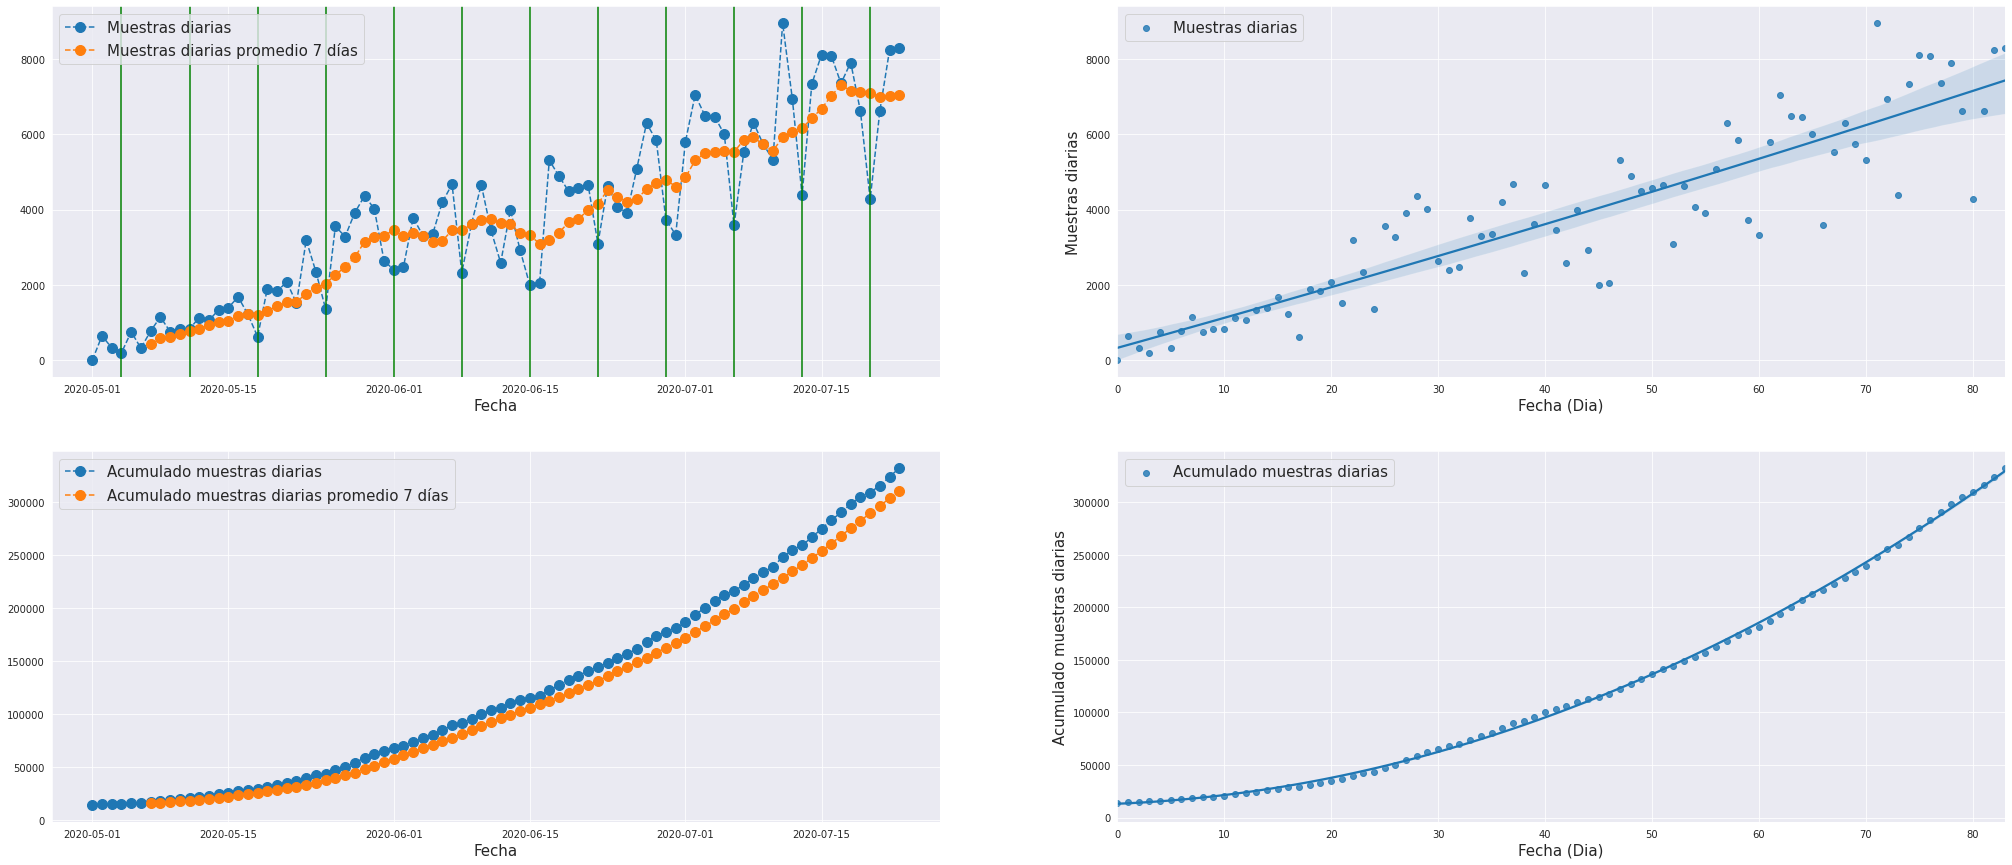

In [16]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(35, 15))

plots(ax1, 'line_plt', datos_arequipa, 'Fecha', 'Muestras diarias', 'muestras_diarias')
plots(ax2, 'reg_sns', datos_arequipa, 'Fecha (Dia)', 'Muestras diarias', 'dia', 'muestras_diarias')
plots(ax3, 'line_plt', datos_arequipa, 'Fecha', 'Acumulado muestras diarias', 'total_muestras')
plots(ax4, 'reg_sns', datos_arequipa, 'Fecha (Dia)', 'Acumulado muestras diarias', 'dia', 'total_muestras')

for date in mondays:
    ax1.axvline(date, color='g')

plt.show()

***CONCLUSIONES: Se puede observar como el numero de pruebas diarias esta aumentando, lo que en realidad es un factor positivo.***



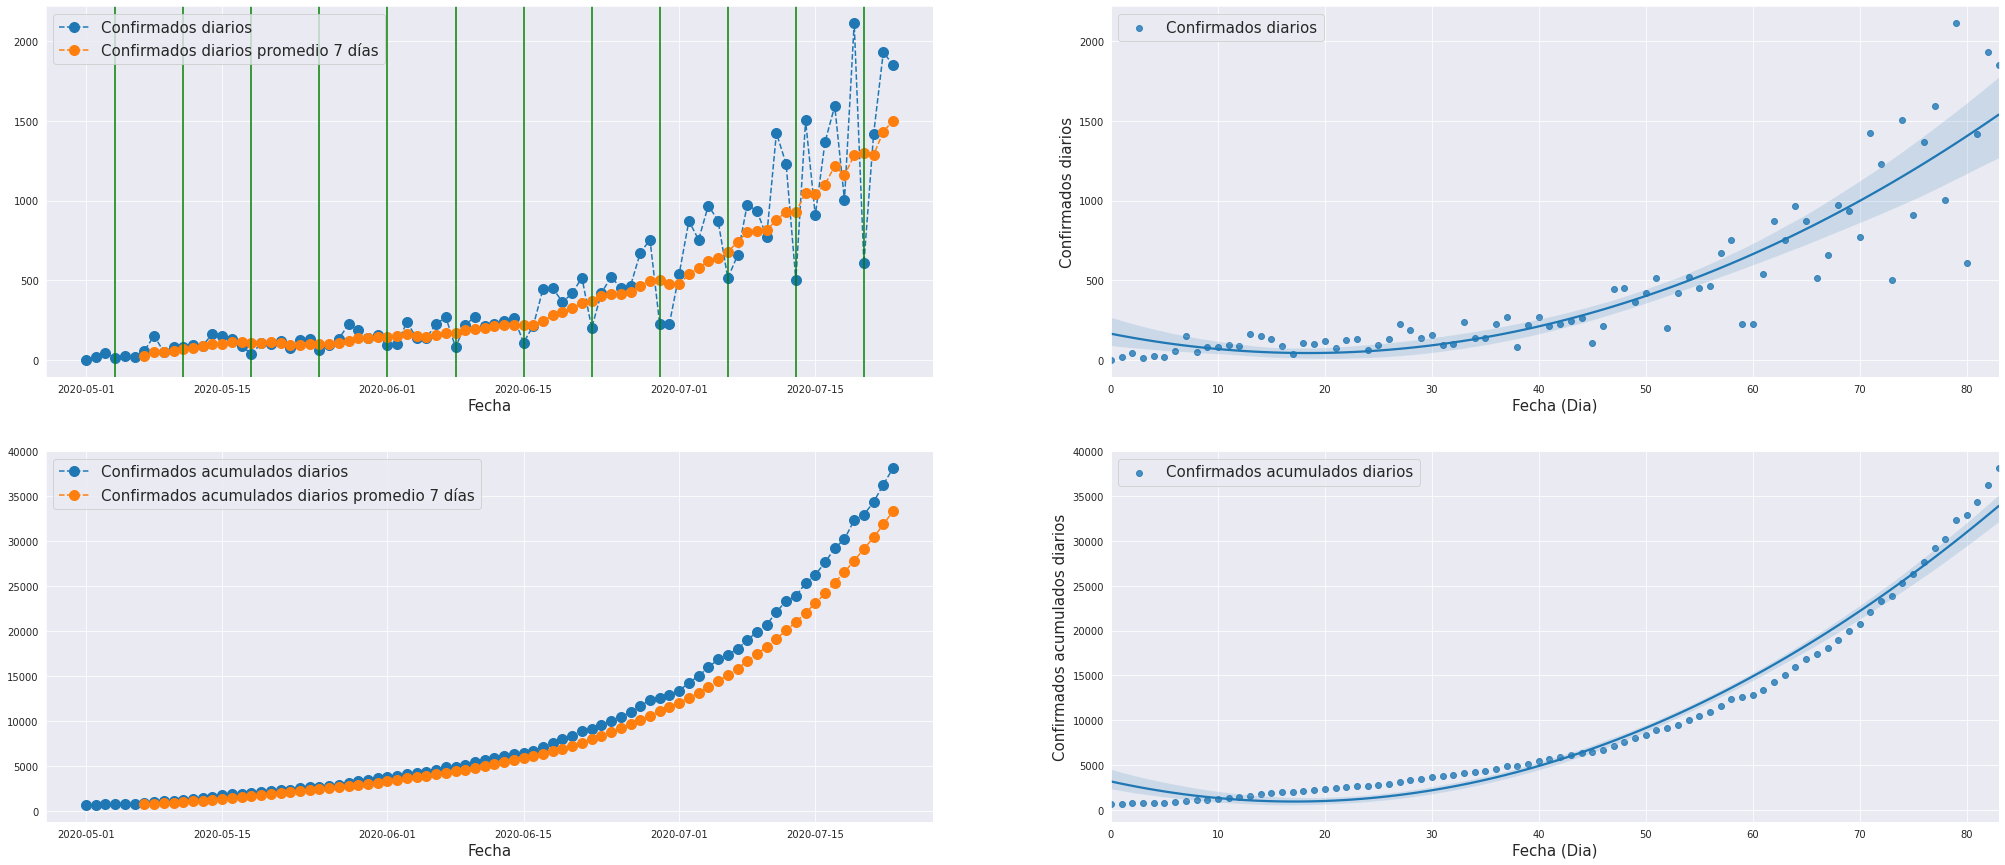

In [17]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(35, 15))

plots(ax1, 'line_plt', datos_arequipa, 'Fecha', 'Confirmados diarios', 'confirmados_diarios')
plots(ax2, 'reg_sns', datos_arequipa, 'Fecha (Dia)', 'Confirmados diarios', 'dia', 'confirmados_diarios')
plots(ax3, 'line_plt', datos_arequipa, 'Fecha', 'Confirmados acumulados diarios', 'casos_positivos')
plots(ax4, 'reg_sns', datos_arequipa, 'Fecha (Dia)', 'Confirmados acumulados diarios', 'dia', 'casos_positivos')

for date in mondays:
    ax1.axvline(date, color='g')

plt.show()

***CONCLUSIONES: Se puede observar como el numero de casos positivos tambien esta aumentando. Haciendo un analisis de regresión, la tendencia es que vaya en aumento.***

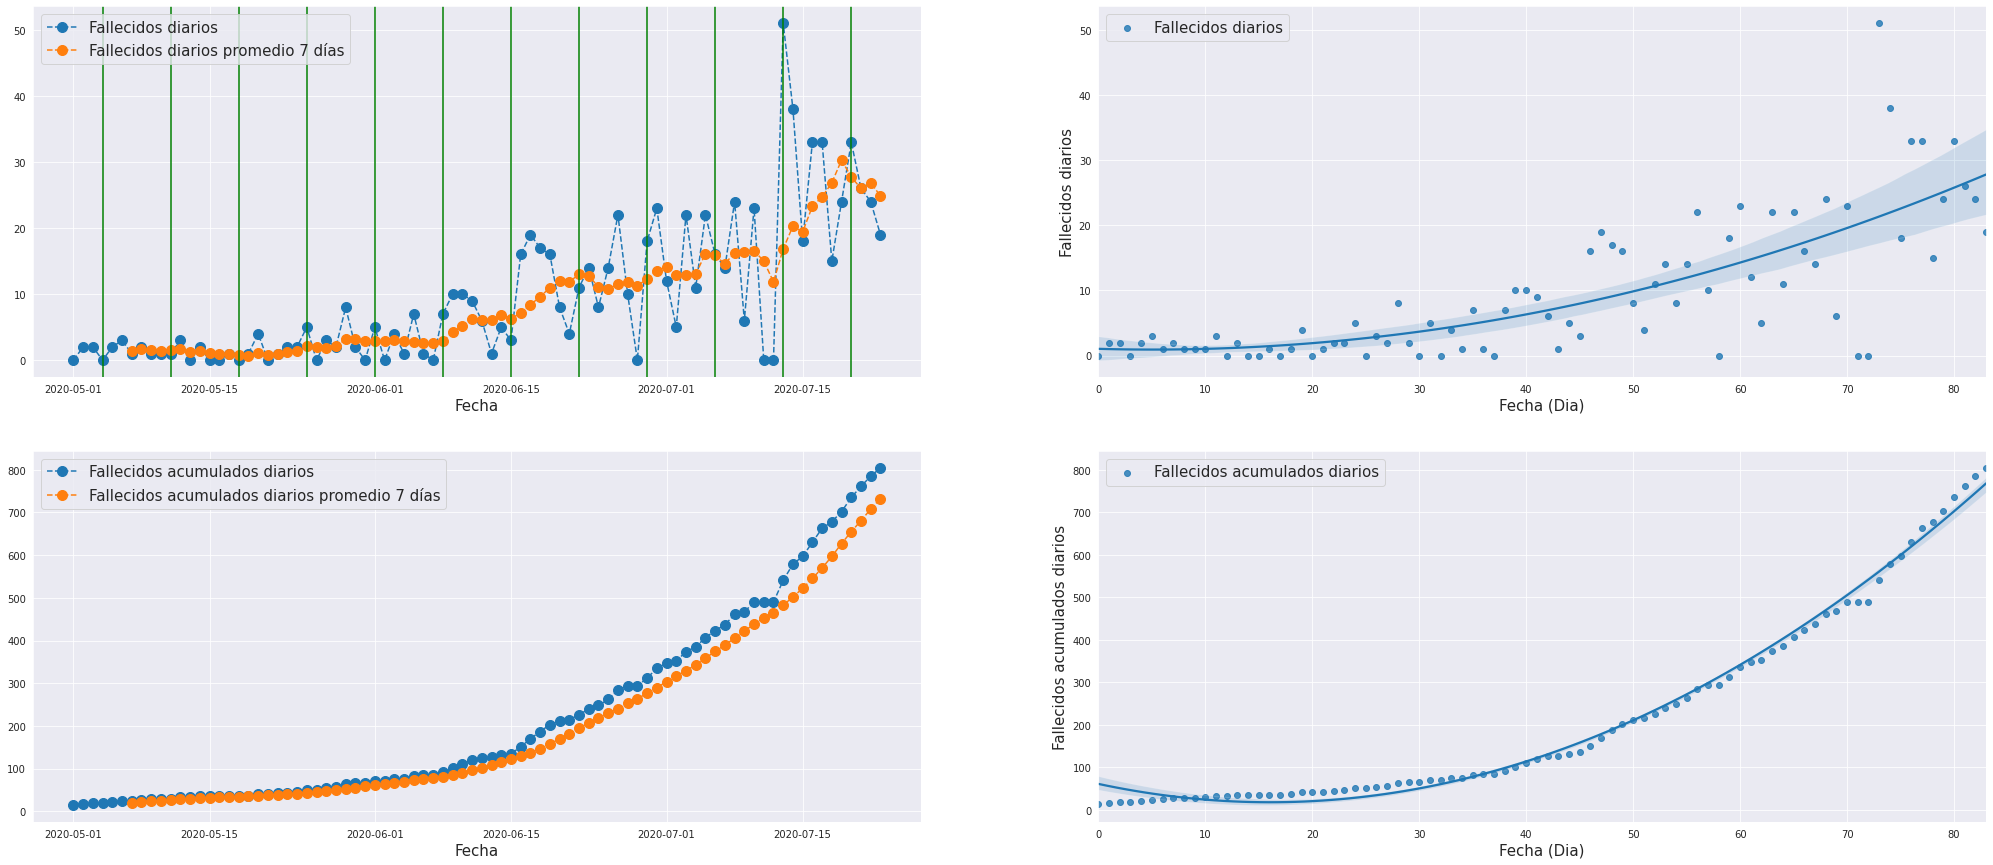

In [18]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(35, 15))

plots(ax1, 'line_plt', datos_arequipa, 'Fecha', 'Fallecidos diarios', 'fallecidos_diarios')
plots(ax2, 'reg_sns', datos_arequipa, 'Fecha (Dia)', 'Fallecidos diarios', 'dia', 'fallecidos_diarios')
plots(ax3, 'line_plt', datos_arequipa, 'Fecha', 'Fallecidos acumulados diarios', 'defunciones')
plots(ax4, 'reg_sns', datos_arequipa, 'Fecha (Dia)', 'Fallecidos acumulados diarios', 'dia', 'defunciones')

for date in mondays:
    ax1.axvline(date, color='g')
plt.show()

***CONCLUSIONES: Se puede observar como el numero de fatalidades tambien esta aumentando. Haciendo un analisis de regresión, la tendencia es que vaya en aumento pero la pendiente no es tan elevada.***

# Positividad

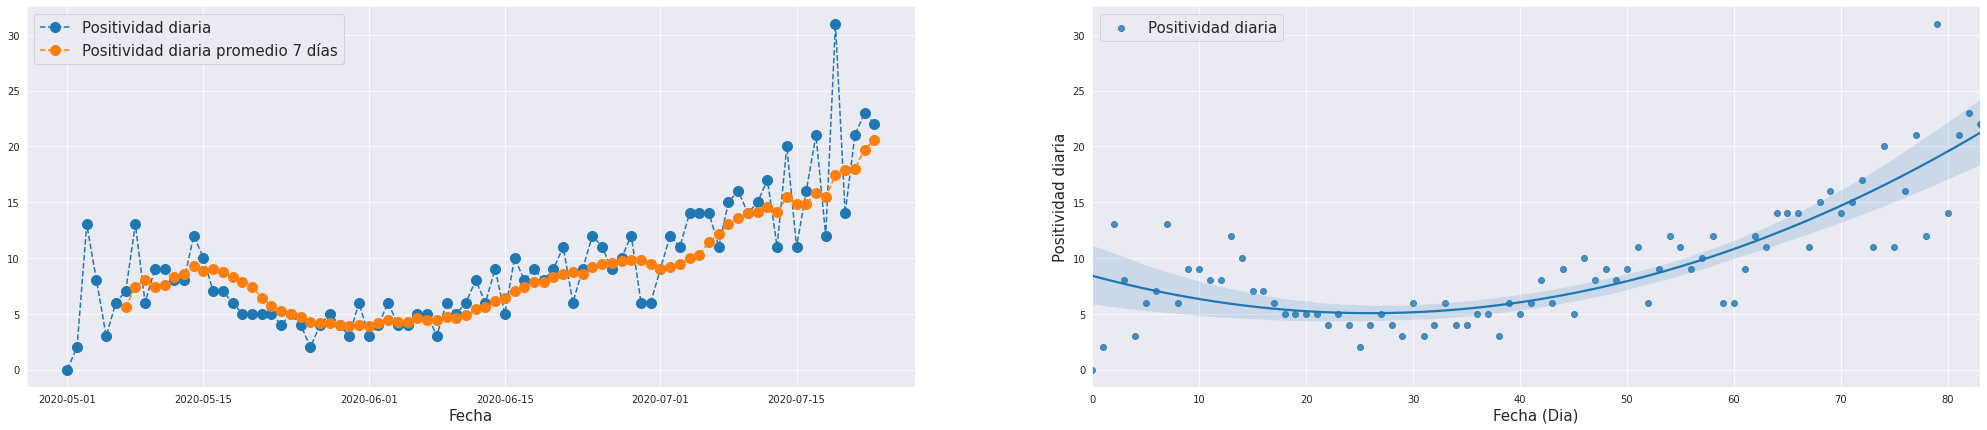

In [19]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(35, 7))

plots(ax1, 'line_plt', datos_arequipa, 'Fecha', 'Positividad diaria', 'positividad')
plots(ax2, 'reg_sns', datos_arequipa, 'Fecha (Dia)', 'Positividad diaria', 'dia', 'positividad')

plt.show()

***CONCLUSIONES: Este es una de las principales métricas y se ve que la positividad va a aumentar y estará entre un 15 y 20% en las proximas semanas.***

# R Factor - Confirmados

In [20]:
r_confirmados_arequipa = datos_arequipa.loc[:,['confirmados_diarios']]
r_confirmados_arequipa['state'] = 'AREQUIPA'
r_confirmados_arequipa = r_confirmados_arequipa.set_index([r_confirmados_arequipa.index, 'state'])
r_confirmados_arequipa = r_confirmados_arequipa['confirmados_diarios']

r_confirmados = run_full_model(r_confirmados_arequipa, sigma=0.01)

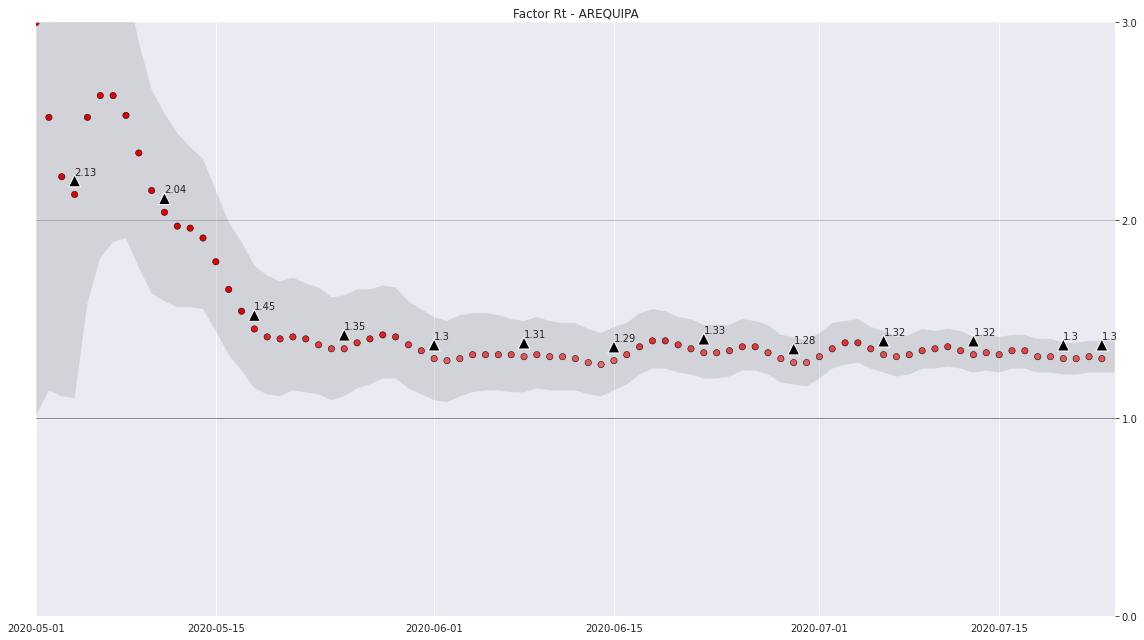

<Figure size 432x288 with 0 Axes>

In [70]:
fig, ax = plt.subplots(figsize=(16, 9))
plot_rt(r_confirmados, ax, 'Factor Rt - AREQUIPA')
fig.tight_layout()
fig.set_facecolor('w')
plt.show()
plt.clf()

***CONCLUSIONES: Este es otra de las principales métricas y se ve que el Factor R se mantiene constante entre 1.4 y 1.5. Este dato es muy preocupante debido a que otros estudios realizados con los datos de todo el país, el tiempo para que este valor este por debajo de 1 es más de un mes. Esto indica a que los contagios no estaran controlados en mínimo un 1 hacia adelante.***

# R Factor - Fallecidos

In [25]:
r_fallecidos_arequipa = datos_arequipa.loc[:,['fallecidos_diarios']]
r_fallecidos_arequipa['state'] = 'AREQUIPA'
r_fallecidos_arequipa = r_fallecidos_arequipa.set_index([r_fallecidos_arequipa.index, 'state'])
r_fallecidos_arequipa = r_fallecidos_arequipa['fallecidos_diarios']

r_fallecidos = run_full_model(r_fallecidos_arequipa, sigma=0.01)

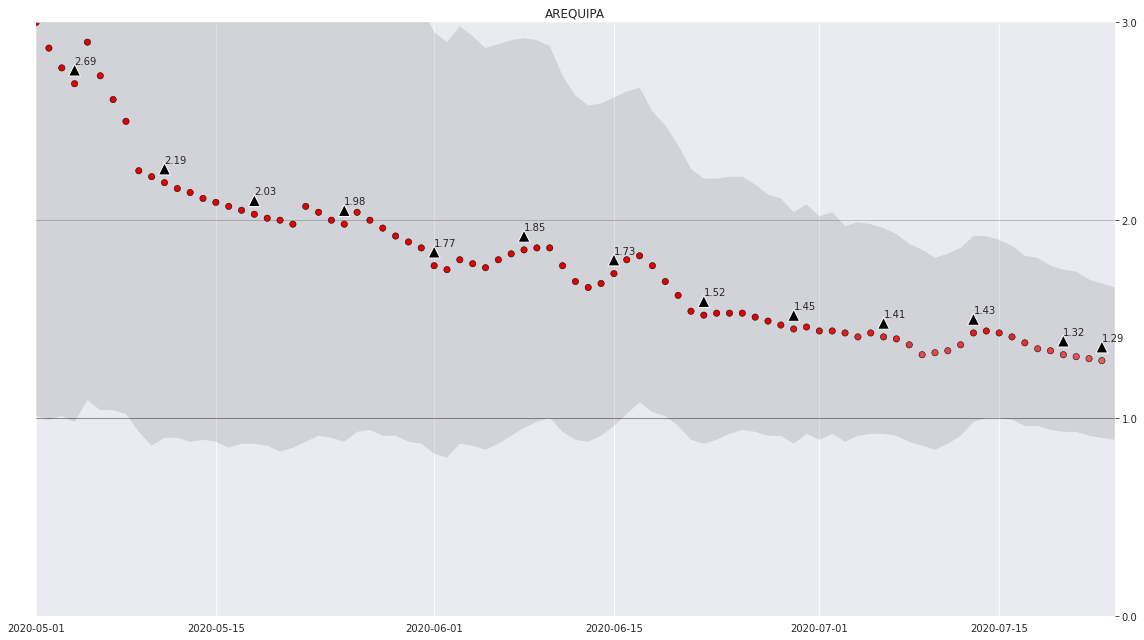

<Figure size 432x288 with 0 Axes>

In [71]:
fig, ax = plt.subplots(figsize=(16, 9))
plot_rt(r_fallecidos, ax, 'AREQUIPA')
fig.tight_layout()
fig.set_facecolor('w')
plt.show()
plt.clf()

# Plot doubling-time: positive cases

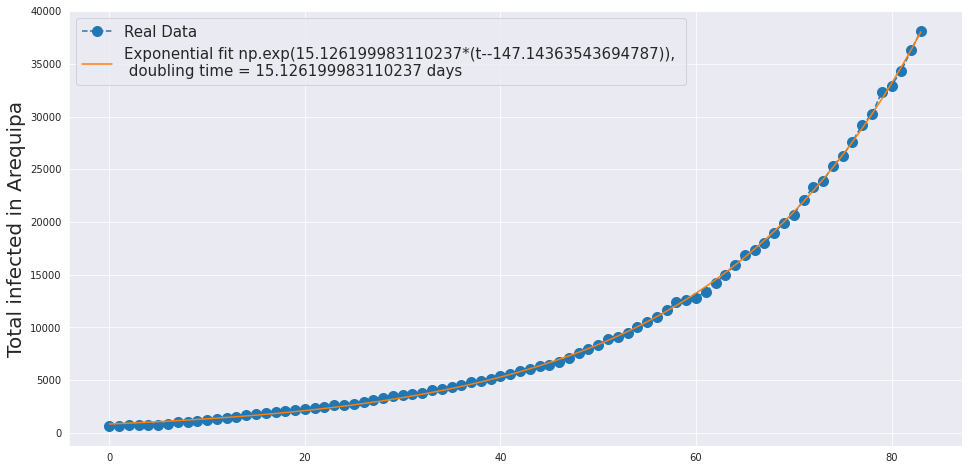

In [27]:
List = []
coeff = prediction_country2(datos_arequipa,'casos_positivos',plot=True)
List.append(coeff)

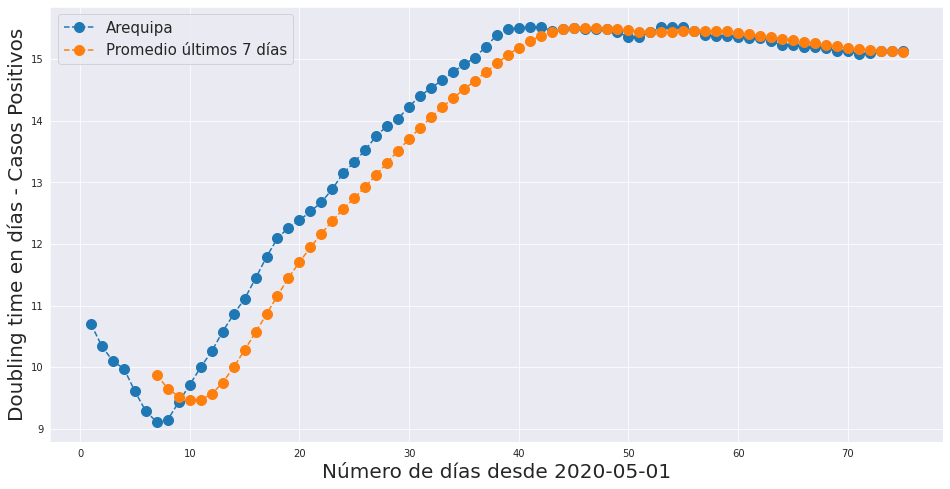

In [28]:
df_combines = pd.DataFrame(List).T
df_combines.columns = df_combines.iloc[0]
df_combines.drop(df_combines.index[0], inplace=True)

dff_double = get_country_double(df_combines, 'Arequipa')
fig,(ax1) = plt.subplots(nrows=1,ncols=1,figsize=(16,8))
ax1.set_ylabel('Doubling time en días - Casos Positivos',fontsize=20)
ax1.set_xlabel('Número de días desde 2020-05-01',fontsize=20)
ax1.plot(dff_double['Doubling Time in Days'],'--o',ms=10,label='Arequipa')
ax1.plot(dff_double['Doubling Time in Days'].rolling(7).mean(),'--o',ms=10,label='Promedio últimos 7 días' )
ax1.legend(fontsize=15)
plt.show()

***CONCLUSIONES: Esta métrica mide el número de dias que los contagios se duplicarán. Con los datos actuales de Arequipa se puede observar que los contagios se duplican cada 15 días. Mientras este valor aumente las medidas en que se están tomando son las adecuadas, pero el caso es totalmente contrario en Arequipa donde la tendencia es a disminuir.***

# Plot doubling-time: deaths

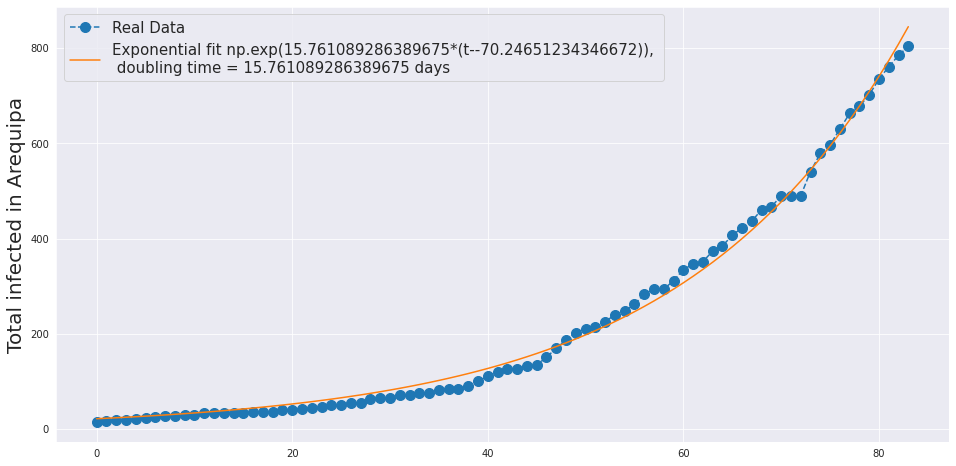

In [ ]:
List = []
coeff = prediction_country2(datos_arequipa,'defunciones',plot=True)
List.append(coeff)

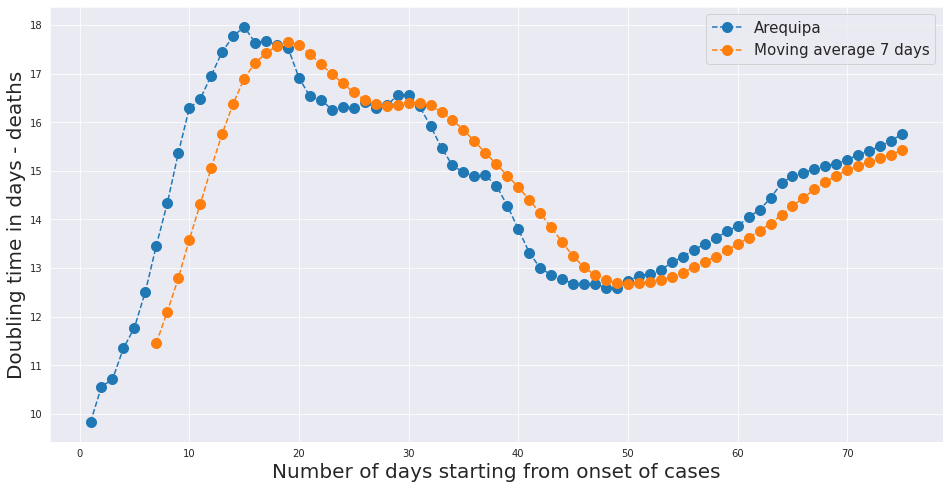

In [ ]:
df_combines = pd.DataFrame(List).T
df_combines.columns = df_combines.iloc[0]
df_combines.drop(df_combines.index[0], inplace=True)

dff_double = get_country_double(df_combines, 'Arequipa')
fig,(ax1) = plt.subplots(nrows=1,ncols=1,figsize=(16,8))
ax1.set_ylabel('Doubling time in days - deaths',fontsize=20)
ax1.set_xlabel('Number of days starting from onset of cases',fontsize=20)
ax1.plot(dff_double['Doubling Time in Days'],'--o',ms=10,label='Arequipa')
ax1.plot(dff_double['Doubling Time in Days'].rolling(7).mean(),'--o',ms=10,label='Moving average 7 days' )
ax1.legend(fontsize=15)
plt.show()

***CONCLUSIONES: Esta métrica mide el número de dias que las fatalidades se duplicarán. Con los datos actuales de Arequipa se puede observar que las fatalidades se duplican también cada 15 días. Caso contrario a los contagios, la tendencia de esta métrica en las fatalidades esta aumentando y ese es un factor positivo.***

# Plots - Defunciones, Activos, Recuperados

In [ ]:
data_map_arequipa = datos_arequipa.loc[:,['casos_positivos', 'defunciones','recuperados','activos','dia']]
data_map_arequipa['hito1'] = data_map_arequipa['defunciones']
data_map_arequipa['hito2'] = data_map_arequipa['defunciones'] + data_map_arequipa['activos']
data_map_arequipa['hito3'] = data_map_arequipa['defunciones'] + data_map_arequipa['activos'] + data_map_arequipa['recuperados']
data_map_arequipa.tail()

,casos_positivos,defunciones,recuperados,activos,dia,hito1,hito2,hito3
date,,,,,,,,
2020-07-19,32336,702,13786,17848,79,702,18550,32336
2020-07-20,32942,735,14626,17581,80,735,18316,32942
2020-07-21,34360,761,15615,17984,81,761,18745,34360
2020-07-22,36291,785,16533,18973,82,785,19758,36291
2020-07-23,38139,804,17410,19925,83,804,20729,38139


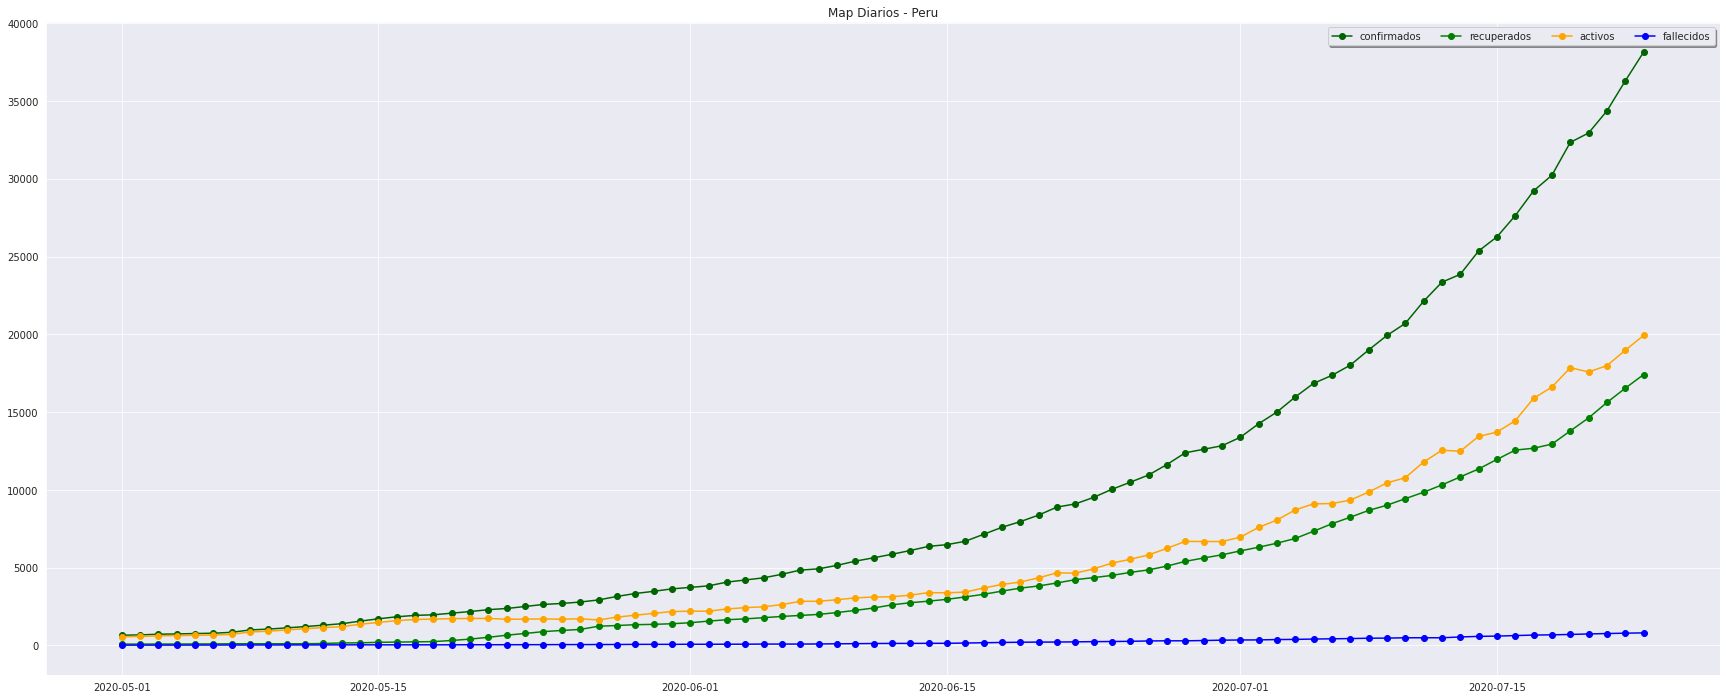

<Figure size 432x288 with 0 Axes>

In [ ]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(30,12))

colors = ['darkgreen', 'green', 'orange', 'blue']
labels = ['confirmados', 'recuperados', 'activos', 'fallecidos']

ax1.plot_date(data_map_arequipa.index, data_map_arequipa['casos_positivos'], color=colors[0], label=labels[0], linestyle="-")
ax1.plot_date(data_map_arequipa.index, data_map_arequipa['recuperados'], color=colors[1], label=labels[1], linestyle="-")
ax1.plot_date(data_map_arequipa.index, data_map_arequipa['activos'], color=colors[2], label=labels[2], linestyle="-")
ax1.plot_date(data_map_arequipa.index, data_map_arequipa['defunciones'], color=colors[3], label=labels[3], linestyle="-")

ax1.set(title='Map Diarios - Peru')

ax1.legend(fancybox=True, shadow=True, ncol=4)

plt.show()
plt.clf()

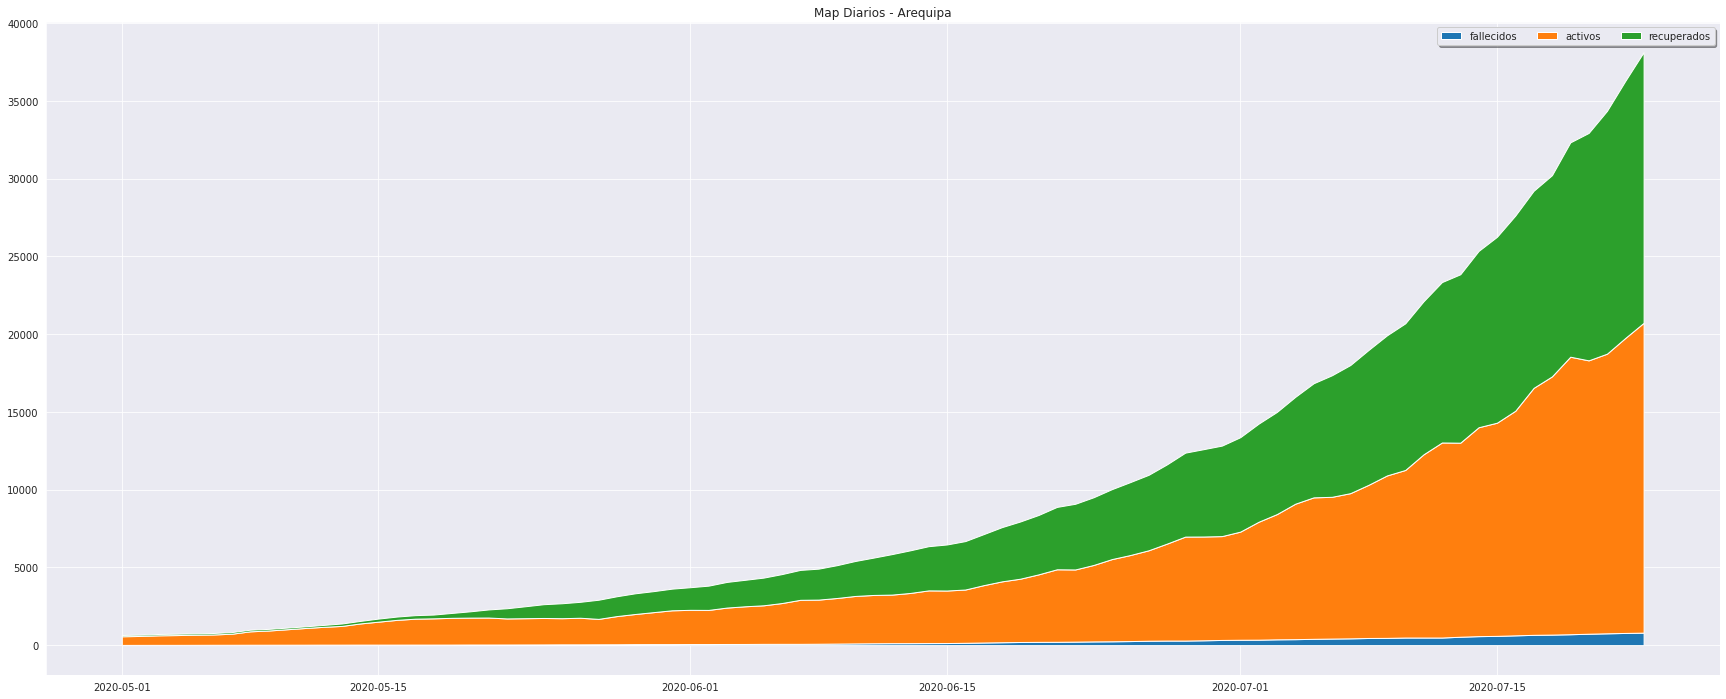

<Figure size 432x288 with 0 Axes>

In [ ]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(30,12))

x1 = data_map_arequipa.index
x2 = data_map_arequipa['hito1']
x3 = data_map_arequipa['hito2']
x4 = data_map_arequipa['hito3']

ax1.fill_between(x1, 0, x2, label='fallecidos')
ax1.fill_between(x1, x2, x3, label='activos')
ax1.fill_between(x1, x3, x4, label='recuperados')

ax1.set(title='Map Diarios - Arequipa')

ax1.legend(fancybox=True, shadow=True, ncol=4)

plt.show()
plt.clf()

***CONCLUSIONES: En este gráfico se puede ver, que a diferencia de los datos de todo el Perú, el area de los activos son mas que los recuperados.***

#Plots - Confirmados diarios vs Recuperados diarios

In [ ]:
daily_confirmados_vs_recuperados = datos_arequipa.loc[:,['confirmados_diarios','recuperados_diarios']]
daily_confirmados_vs_recuperados['diario_c_vs_r'] = daily_confirmados_vs_recuperados.recuperados_diarios / \
                                                    daily_confirmados_vs_recuperados.confirmados_diarios

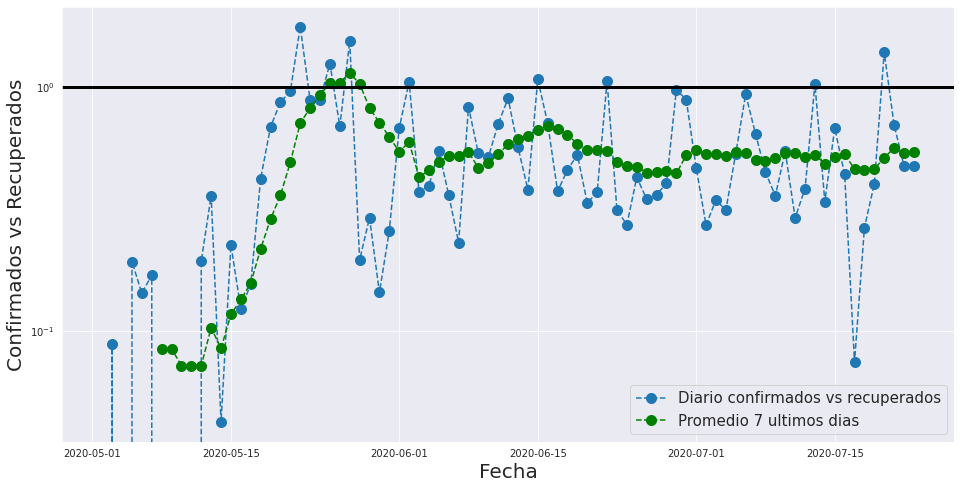

In [ ]:
fig,ax1 = plt.subplots(nrows=1,ncols=1,figsize=(16,8))
ax1.set_ylabel('Confirmados vs Recuperados',fontsize=20)
ax1.set_xlabel('Fecha',fontsize=20)
#ax1.bar(daily_confirmados_vs_recuperados.index, daily_confirmados_vs_recuperados['diario_c_vs_r'],label='Diario confirmados vs recuperados')
ax1.plot(daily_confirmados_vs_recuperados['diario_c_vs_r'],'--o',ms=10,label='Diario confirmados vs recuperados')
ax1.plot(daily_confirmados_vs_recuperados['diario_c_vs_r'].rolling(7).mean(),'--o',ms=10,label='Promedio 7 ultimos dias', color='green')
ax1.legend(fontsize=15)
ax1.set_yscale('log')

plt.axhline(1, color='k',lw=3)
plt.show()

***CONCLUSIONES: En este gráfico se puede ver que solo entre el 20 y el 25 de Mayo la tasa de recuperados supero a la de contagiados, luego las tasa de recuperados es inferior a los contagiados.***

# SIR Function

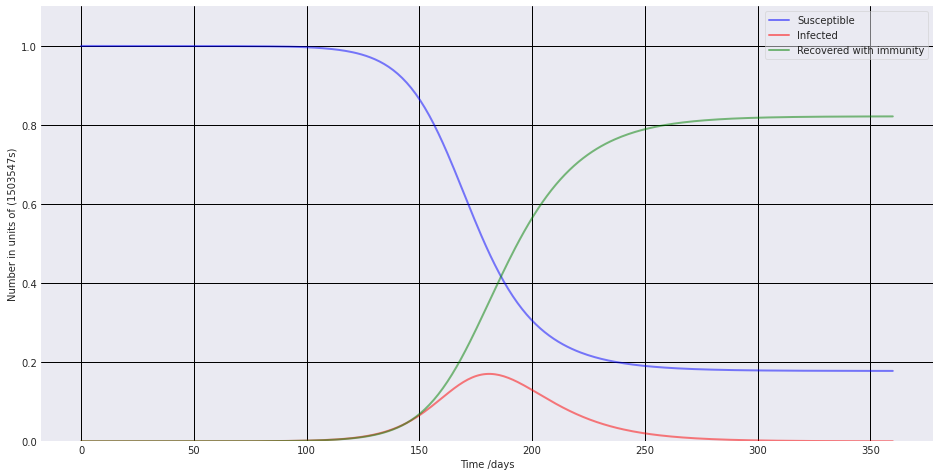

In [ ]:
from scipy.integrate import odeint

# Total population, Arequipa
N = 1503547
# Initial number of infected and recovered individuals, I0 and R0.
I0, R0 = 1, 0
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0
# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
beta, gamma = 0.15, 1/14    #  https://www.worldometers.info/coronavirus/coronavirus-incubation-period/#24
# A grid of time points (in days)
t = np.linspace(0, 360, 360)

# The SIR model differential equations.
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

# Initial conditions vector
y0 = S0, I0, R0
# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, beta, gamma))
S, I, R = ret.T

# Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(facecolor='w',figsize=(16,8))
ax = fig.add_subplot(111,  axisbelow=True)
ax.plot(t, S/N, 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(t, I/N, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(t, R/N, 'g', alpha=0.5, lw=2, label='Recovered with immunity')
ax.set_xlabel('Time /days')
ax.set_ylabel('Number in units of ('+str(N)+'s)')
ax.set_ylim(0,1.1)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='both',axis='both', c='black', lw=1, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

***CONCLUSIONES: Esta función grafíca el comportamiento del coronavirus con los datos de Arequipa. Los datos importantes son:***

1.   Poblacion de Arequipa: 1503547
2.   Contact rate (beta) : Diversos estudios catalogarón que en esta pandemia este valor se encontraría entre 0.2 y 0.3. (Se necesita mas investigación pero en caso del Perú un beta de 0.15 gráfica mejor la situación actual).
3.   Mean recovery rate (gamma): Básicamente este valor es 1/<Periodo de incubación>. Este dato para Perú es de 14 días.

Se puede observar que el límite de contagios en Arequipa llegaría en aproximadamente al día 170 y 180 que se inició la pandemia. Esto sería en un mes aproximadamente.


# Estudio por dias de la semana

In [ ]:
url = 'https://www.datosabiertos.gob.pe/node/6447/download/positivos_covid.csv'

datos_minsa = pd.read_csv(url, encoding = "ISO-8859-1") 

In [ ]:
display(datos_minsa.shape)
datos_minsa.tail()

(366550, 8)

,UUID,DEPARTAMENTO,PROVINCIA,DISTRITO,METODODX,EDAD,SEXO,FECHA_RESULTADO
366545,BB762688154AF7333F81438251594AB4,ANCASH,SANTA,NUEVO CHIMBOTE,PR,2,MASCULINO,2020-05-21
366546,32ECB97AD54BA93FC0C77077EDBCA651,ANCASH,SANTA,CHIMBOTE,PR,1,MASCULINO,2020-05-01
366547,301C7B5FC2936B0F6FB65919E5AF24A4,ANCASH,HUARAZ,HUARAZ,PR,8,MASCULINO,2020-05-19
366548,C8243DA679B3168C5B38A973D2F00B7D,ANCASH,HUARAZ,HUARAZ,PR,5,MASCULINO,2020-05-24
366549,0B9D289C475B1D9DE65BC0DDDFAC806D,ANCASH,SANTA,COISHCO,PR,11,MASCULINO,2020-05-05


In [ ]:
datos_minsa['EDAD'] = datos_minsa['EDAD'].fillna(0)
datos_minsa['EDAD'] = datos_minsa['EDAD'].astype('int')
datos_minsa['FECHA_RESULTADO'] = pd.to_datetime(datos_minsa['FECHA_RESULTADO'], dayfirst=True)

datos_minsa = datos_minsa.apply(lambda x: x.str.upper() if x.dtype == "object" else x)  

In [ ]:
display(datos_minsa.info())
display(datos_minsa.sort_values('FECHA_RESULTADO'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366550 entries, 0 to 366549
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   UUID             366550 non-null  object        
 1   DEPARTAMENTO     366550 non-null  object        
 2   PROVINCIA        366550 non-null  object        
 3   DISTRITO         366550 non-null  object        
 4   METODODX         366550 non-null  object        
 5   EDAD             366550 non-null  int64         
 6   SEXO             364552 non-null  object        
 7   FECHA_RESULTADO  366028 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(6)
memory usage: 22.4+ MB


None

,UUID,DEPARTAMENTO,PROVINCIA,DISTRITO,METODODX,EDAD,SEXO,FECHA_RESULTADO
11690,19BDA6B23AF69559B4A31AC57B7D2463,LIMA,LIMA,LA MOLINA,PCR,25,MASCULINO,2020-03-06
11696,240F20BCA142E7C1098E0F9C3457F9D0,LIMA,LIMA,SANTIAGO DE SURCO,PCR,51,MASCULINO,2020-03-07
11694,80FDBADB91C9697DF15329E6824E73D9,LIMA,LIMA,SANTIAGO DE SURCO,PCR,25,MASCULINO,2020-03-07
11693,735FA4E5073B24554F8527E2C249C2C9,LIMA,LIMA,SANTIAGO DE SURCO,PCR,7,MASCULINO,2020-03-07
11688,2CCA4BCD3CD4F29AA8B56E674EA0C618,LIMA,LIMA,SANTIAGO DE SURCO,PCR,74,FEMENINO,2020-03-07
...,...,...,...,...,...,...,...,...
350683,B6A83043F66DB3EE7D0A2828A1C43BCE,LIMA,LIMA,LOS OLIVOS,PR,0,FEMENINO,NaT
350684,046F18D407D62A7B6E83E26070939791,LIMA REGION,EN INVESTIGACIÓN,EN INVESTIGACIÓN,PR,0,FEMENINO,NaT
356987,D7F1B4A6F801FB79477F9466A4039DD2,LIMA,LIMA,SAN BORJA,PR,31,MASCULINO,NaT
356988,74E50A394C3A8D8D87D205ACF5E060EA,LIMA,LIMA,PUENTE PIEDRA,PR,27,MASCULINO,NaT


In [ ]:
datos_minsa_cut = datos_minsa.query('FECHA_RESULTADO >= \"2020-03-29\" & FECHA_RESULTADO <= \"2020-07-23\"')

In [ ]:
datos_minsa_cut = datos_minsa_cut.reset_index(drop=True)
display(datos_minsa_cut.info())
display(datos_minsa_cut.tail())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365234 entries, 0 to 365233
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   UUID             365234 non-null  object        
 1   DEPARTAMENTO     365234 non-null  object        
 2   PROVINCIA        365234 non-null  object        
 3   DISTRITO         365234 non-null  object        
 4   METODODX         365234 non-null  object        
 5   EDAD             365234 non-null  int64         
 6   SEXO             363688 non-null  object        
 7   FECHA_RESULTADO  365234 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(6)
memory usage: 22.3+ MB


None

,UUID,DEPARTAMENTO,PROVINCIA,DISTRITO,METODODX,EDAD,SEXO,FECHA_RESULTADO
365229,BB762688154AF7333F81438251594AB4,ANCASH,SANTA,NUEVO CHIMBOTE,PR,2,MASCULINO,2020-05-21
365230,32ECB97AD54BA93FC0C77077EDBCA651,ANCASH,SANTA,CHIMBOTE,PR,1,MASCULINO,2020-05-01
365231,301C7B5FC2936B0F6FB65919E5AF24A4,ANCASH,HUARAZ,HUARAZ,PR,8,MASCULINO,2020-05-19
365232,C8243DA679B3168C5B38A973D2F00B7D,ANCASH,HUARAZ,HUARAZ,PR,5,MASCULINO,2020-05-24
365233,0B9D289C475B1D9DE65BC0DDDFAC806D,ANCASH,SANTA,COISHCO,PR,11,MASCULINO,2020-05-05


In [ ]:
display(datos_minsa_cut['FECHA_RESULTADO'].min())
display(datos_minsa_cut['FECHA_RESULTADO'].max())

Timestamp('2020-03-29 00:00:00')

Timestamp('2020-07-21 00:00:00')

In [ ]:
df_arequipa_dep = datos_minsa_cut[datos_minsa_cut['DEPARTAMENTO'] == 'AREQUIPA']
df_arequipa_dep['WEEKDAY'] = df_arequipa_dep['FECHA_RESULTADO'].dt.weekday
df_arequipa_dep = df_arequipa_dep.reset_index(drop=True)
display(df_arequipa_dep.shape)
display(df_arequipa_dep.tail())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


(10794, 9)

,UUID,DEPARTAMENTO,PROVINCIA,DISTRITO,METODODX,EDAD,SEXO,FECHA_RESULTADO,WEEKDAY
10789,9807922E241C172C3D20251F2E21AE71,AREQUIPA,AREQUIPA,ALTO SELVA ALEGRE,PR,18,MASCULINO,2020-05-21,3
10790,13E56E91CF2BBFA40A38D67500E0892F,AREQUIPA,AREQUIPA,CAYMA,PR,20,MASCULINO,2020-05-08,4
10791,AB8287281F8C281FDDDA97638D40FA0E,AREQUIPA,CARAVELI,LOMAS,PR,23,MASCULINO,2020-05-20,2
10792,9ED7BF861FEB84B573803848E91D3FC2,AREQUIPA,AREQUIPA,JOSE LUIS BUSTAMANTE Y RIVERO,PR,28,MASCULINO,2020-04-19,6
10793,E59429778F2CA2D0533743B6BC11E20A,AREQUIPA,AREQUIPA,JACOBO HUNTER,PR,29,MASCULINO,2020-05-23,5


PROVINCIA         SEXO     
AREQUIPA          MASCULINO    5786
                  FEMENINO     3948
CAYLLOMA          MASCULINO     166
ISLAY             MASCULINO     139
                  FEMENINO      135
CARAVELI          MASCULINO     126
CAYLLOMA          FEMENINO      116
CARAVELI          FEMENINO      103
CAMANA            MASCULINO      75
CASTILLA          MASCULINO      49
CAMANA            FEMENINO       47
EN INVESTIGACIÓN  MASCULINO      31
                  FEMENINO       28
CASTILLA          FEMENINO       22
CONDESUYOS        MASCULINO       7
LA UNION          MASCULINO       6
CONDESUYOS        FEMENINO        5
LA UNION          FEMENINO        4
Name: UUID, dtype: int64

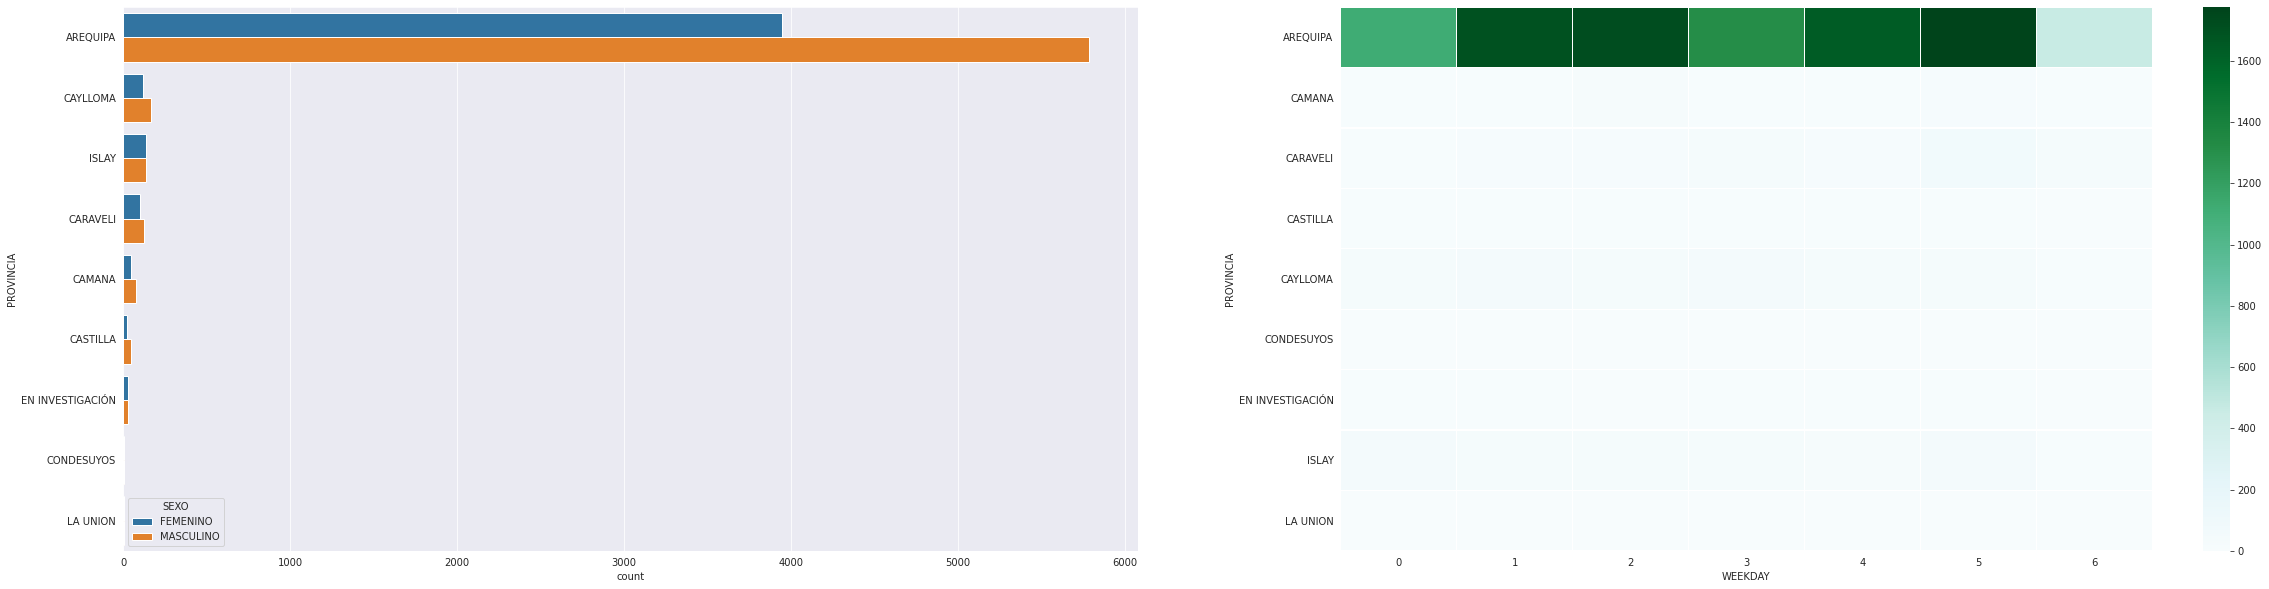

In [ ]:
pd_arequipa_dep_crosstab = pd.crosstab(df_arequipa_dep["PROVINCIA"], df_arequipa_dep["WEEKDAY"])

display(df_arequipa_dep.groupby(['PROVINCIA', 'SEXO'])['UUID'].count().sort_values(ascending=False))

fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2, figsize=(40,10))

sns.countplot(data=df_arequipa_dep, y='PROVINCIA', order = df_arequipa_dep['PROVINCIA'].value_counts().index, hue='SEXO', ax = ax1)
sns.heatmap(pd_arequipa_dep_crosstab, cmap="BuGn", linewidths=0.3, ax = ax2)

plt.show()

In [ ]:
df_arequipa_pro = datos_minsa_cut[(datos_minsa_cut['DEPARTAMENTO'] == 'AREQUIPA') & (datos_minsa_cut['PROVINCIA'] == 'AREQUIPA')].reset_index(drop=True)
df_arequipa_pro['WEEKDAY'] = df_arequipa_pro['FECHA_RESULTADO'].dt.weekday
display(df_arequipa_pro.shape)
display(df_arequipa_pro.tail())

(9735, 9)

,UUID,DEPARTAMENTO,PROVINCIA,DISTRITO,METODODX,EDAD,SEXO,FECHA_RESULTADO,WEEKDAY
9730,02CAAE6C3D0EA2960704DFB989D1F8D8,AREQUIPA,AREQUIPA,AREQUIPA,PR,19,MASCULINO,2020-04-24,4
9731,9807922E241C172C3D20251F2E21AE71,AREQUIPA,AREQUIPA,ALTO SELVA ALEGRE,PR,18,MASCULINO,2020-05-21,3
9732,13E56E91CF2BBFA40A38D67500E0892F,AREQUIPA,AREQUIPA,CAYMA,PR,20,MASCULINO,2020-05-08,4
9733,9ED7BF861FEB84B573803848E91D3FC2,AREQUIPA,AREQUIPA,JOSE LUIS BUSTAMANTE Y RIVERO,PR,28,MASCULINO,2020-04-19,6
9734,E59429778F2CA2D0533743B6BC11E20A,AREQUIPA,AREQUIPA,JACOBO HUNTER,PR,29,MASCULINO,2020-05-23,5


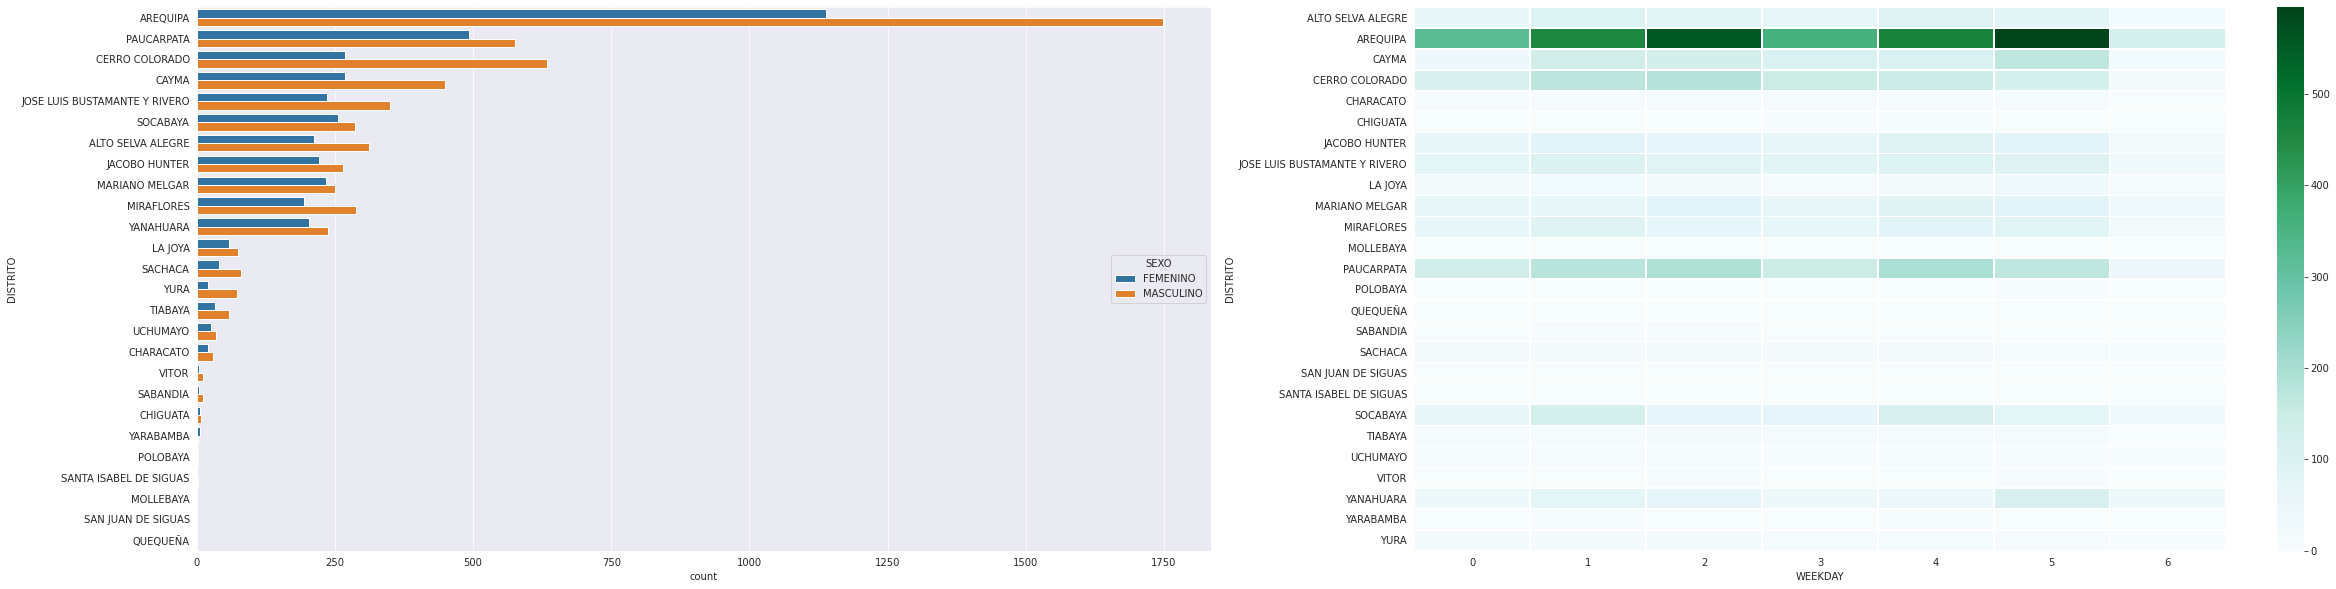

In [ ]:
pd_arequipa_pro_crosstab = pd.crosstab(df_arequipa_pro["DISTRITO"], df_arequipa_pro["WEEKDAY"])

fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2, figsize=(40,10))

sns.countplot(data=df_arequipa_pro, y='DISTRITO', order = df_arequipa_pro['DISTRITO'].value_counts().index, hue = 'SEXO', ax = ax1)
sns.heatmap(pd_arequipa_pro_crosstab, cmap="BuGn", linewidths=0.3, ax = ax2)

plt.show()

***CONCLUSIONES: Esta, aunque no parezca, es una métrica importante; indica, aproximadamente, cuando es que las personas de Arequipa contraen el virus. Según la OMS, el virus tiende a provocar sintomas entre 5 y 6 días después de la exposición (pero pude variar entre 1 y 14 días), debido a la actual realidad de Arequipa (la temporada de invierno), en este estudio se cree que los sintomas tienden a aparecer lo mas antes posible (5 días).***

***Como vemos en las gráficas, los días (dentro de la provincia de Arequipa), que mas personas son diagnosticadas con COVID-19 son los MIERCOLES y SABADOS, si a estos días le quitamos los 5 días que demoraría una persona normal en tener los sintomas, eso quiere decir que las personas tienden a contagiarse más los días SABADOS y MARTES. SE SUGIERE A LAS PERSONAS NO SALIR LOS DIAS SABADO, LUNES Y MARTES***

***Referencia : https://www.who.int/emergencies/diseases/novel-coronavirus-2019/technical-guidance/naming-the-coronavirus-disease-(covid-2019)-and-the-virus-that-causes-it***

***Tenemos que notar que los datos para esta métrica son extraídos de los datos liberados del MINSA.***

In [ ]:
df_edad = df_arequipa_pro.EDAD
#df_edad.replace([0], np.nan, inplace=True)
display(df_edad.value_counts().sort_index().shape)
df_edad.describe()

(100,)

count    9712.000000
mean       46.702739
std        17.096571
min         1.000000
25%        34.000000
50%        45.000000
75%        58.000000
max       106.000000
Name: EDAD, dtype: float64

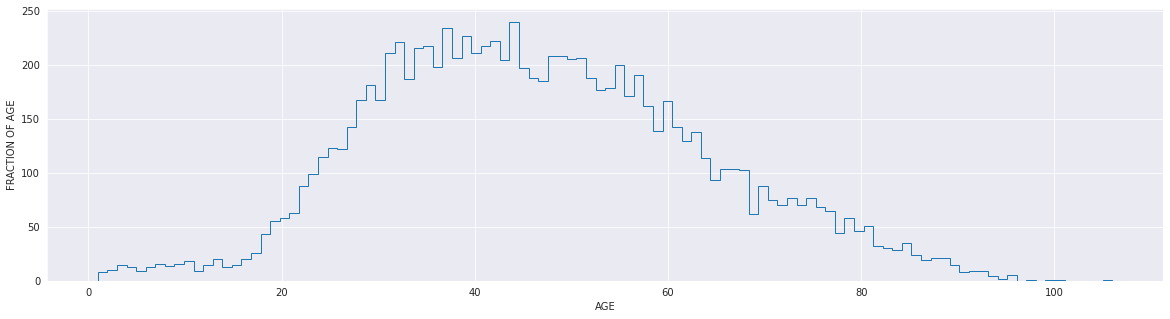

In [ ]:
plt.figure(figsize=(20,5))
plt.hist(df_edad.dropna(), bins=106, histtype='step')
plt.xlabel('AGE')
plt.ylabel('FRACTION OF AGE')
plt.show()

In [ ]:
is_masculine = df_arequipa_pro.SEXO == 'MASCULINO'
is_PCR = df_arequipa_pro.METODODX == 'PCR'
edad_sex_masculine = df_edad[is_masculine]
edad_sex_femenine = df_edad[~is_masculine]
print('Promedio de Edad Hombres: ', edad_sex_masculine.mean())
print('Promedio de Edad Mujeres: ',edad_sex_femenine.mean())

edad_sex_masculine_pcr = df_edad[is_masculine & is_PCR]
edad_sex_femenine_pcr = df_edad[~is_masculine & is_PCR]
print('Promedio de Edad Hombres - PCR: ',edad_sex_masculine_pcr.mean())
print('Promedio de Edad Mujeres - PCR: ',edad_sex_femenine_pcr.mean())

Promedio de Edad Hombres:  46.82689308612026
Promedio de Edad Mujeres:  46.52093377315402
Promedio de Edad Hombres - PCR:  52.99472140762463
Promedio de Edad Mujeres - PCR:  51.899733806566104


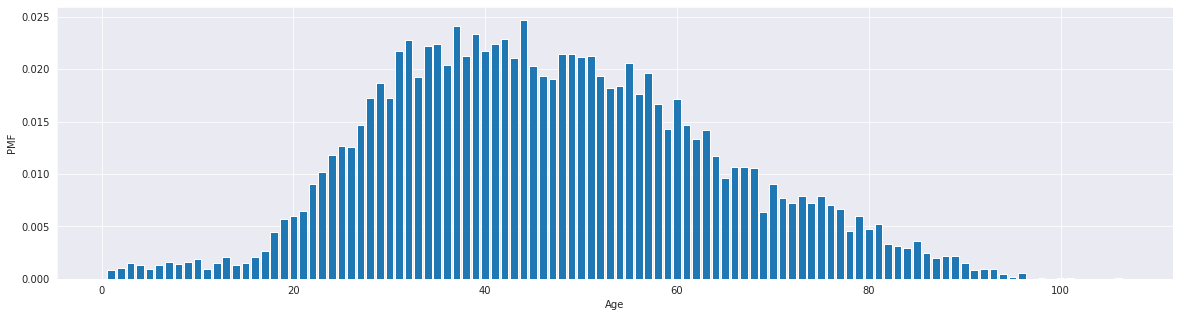

In [ ]:
pmf_age_result = Pmf.from_seq(df_edad)
# Plot the PMF
plt.figure(figsize=(20,5))
pmf_age_result.bar()

# Label the axes
plt.xlabel('Age')
plt.ylabel('PMF')
plt.show()

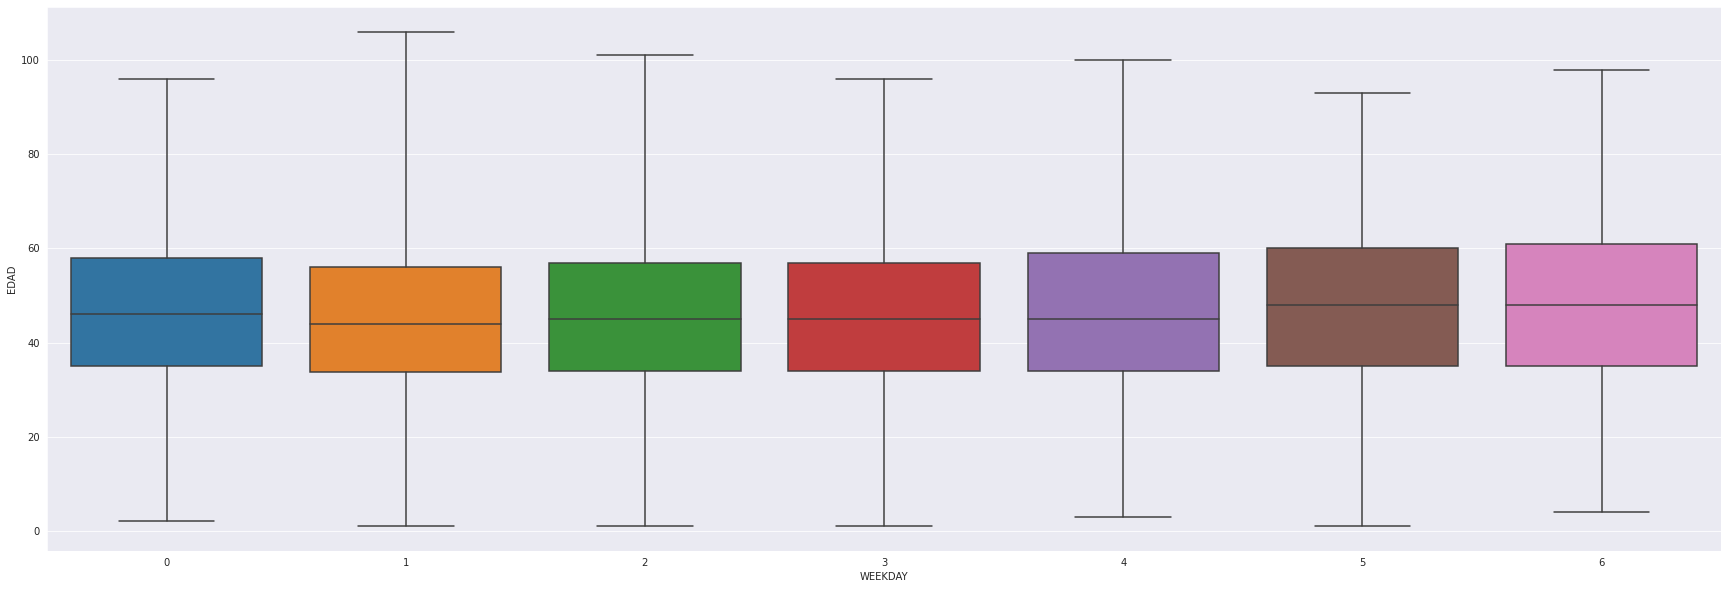

In [ ]:
plt.figure(figsize=(30,10))
sns.boxplot(data = df_arequipa_pro, x='WEEKDAY', y='EDAD', whis=10)
#plt.yscale('log')
plt.show()

# Varios

In [ ]:
! pip install empiricaldist

  Created wheel for empiricaldist: filename=empiricaldist-0.3.8-cp36-none-any.whl size=10156 sha256=52d91307969e8ec540e68f6dbb554f836d8dc322a295c1064d3b06a3c360b32b
  Stored in directory: /root/.cache/pip/wheels/46/48/e3/5d4d76a8cd55dd92a7fdd53355867ee512d70dffa065c9f510
Successfully built empiricaldist


In [ ]:
from empiricaldist import Pmf, Cdf

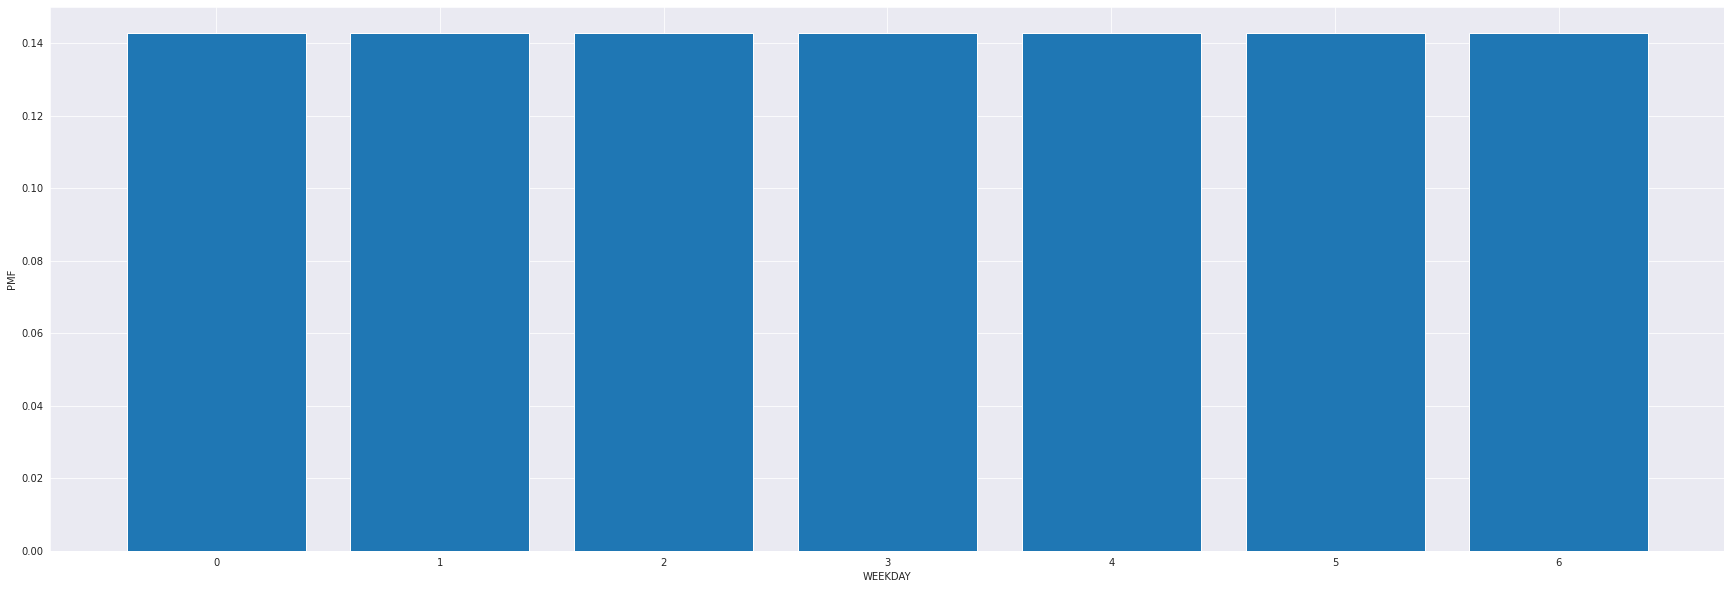

In [ ]:
metododx = datos_arequipa['weekday']
plt.figure(figsize=(30,10))
Pmf.from_seq(metododx).bar()

plt.xlabel('WEEKDAY')
plt.ylabel('PMF')
plt.show()

# Estudios de correlacion y regresion

In [ ]:
datos_arequipa.tail()

,total_muestras,casos_positivos,casos_negativos,espera_resultado,defunciones,recuperados,hospitalizados_positivos,hospitalizados_sospechosos,uci_positivos,uci_sospechosos,defunciones_minsa,defunciones_essalud,defunciones_clinicas,defunciones_domicilio,defunciones_sanidades,dia,weekday,muestras_diarias,confirmados_diarios,fallecidos_diarios,recuperados_diarios,positividad,activos
date,,,,,,,,,,,,,,,,,,,,,,,
2020-07-19,305098,32336,272744,18,702,13786,435,230,51,13,223,421,12,38,8,79,6,6617,2111,24,846,31,17848
2020-07-20,309374,32942,276414,18,735,14626,424,225,49,13,237,439,12,38,9,80,0,4276,606,33,840,14,17581
2020-07-21,316006,34360,281587,95,761,15615,421,239,50,14,246,456,12,38,9,81,1,6632,1418,26,989,21,17984
2020-07-22,324257,36291,287907,59,785,16533,421,239,50,14,257,469,12,38,9,82,2,8251,1931,24,918,23,18973
2020-07-23,332543,38139,294367,37,804,17410,414,223,52,15,276,469,12,38,9,83,3,8286,1848,19,877,22,19925


In [ ]:
datos_arequipa.describe()

,total_muestras,casos_positivos,casos_negativos,espera_resultado,defunciones,recuperados,hospitalizados_positivos,hospitalizados_sospechosos,uci_positivos,uci_sospechosos,defunciones_minsa,defunciones_essalud,defunciones_clinicas,defunciones_domicilio,defunciones_sanidades,dia,weekday,muestras_diarias,confirmados_diarios,fallecidos_diarios,recuperados_diarios,positividad,activos
count,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000
mean,124932.857143,9897.904762,114988.250000,43.976190,224.678571,4274.392857,217.440476,110.761905,40.761905,9.869048,76.369048,123.285714,3.583333,5.964286,1.952381,41.500000,3.000000,3789.702381,446.238095,9.392857,206.273810,9.166667,5398.833333
std,95543.990584,9989.535930,85829.682996,54.547642,226.520573,4587.978170,154.947745,88.027600,15.239153,6.706910,76.863951,133.881315,4.464609,11.516825,2.845012,24.392622,2.012012,2314.601013,491.159524,10.649982,231.700802,5.481257,5185.697580
min,14208.000000,655.000000,13552.000000,0.000000,15.000000,83.000000,40.000000,0.000000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,557.000000
25%,36209.500000,2354.000000,33823.000000,8.000000,41.750000,621.500000,74.000000,31.000000,24.750000,4.000000,11.750000,25.000000,0.000000,0.000000,0.000000,20.750000,1.000000,1883.750000,104.750000,1.000000,51.500000,5.000000,1688.750000
50%,104859.000000,5742.500000,99091.500000,26.000000,123.000000,2503.000000,174.000000,89.500000,47.500000,8.000000,43.000000,53.000000,0.000000,0.000000,0.000000,41.500000,3.000000,3675.000000,225.000000,5.000000,133.000000,8.000000,3116.500000
75%,195541.750000,14434.750000,181063.000000,57.500000,357.500000,6375.000000,349.250000,187.000000,53.250000,14.250000,133.250000,202.000000,6.000000,3.000000,4.000000,62.250000,5.000000,5379.750000,618.500000,16.000000,254.000000,12.000000,7702.250000
max,332543.000000,38139.000000,294367.000000,258.000000,804.000000,17410.000000,598.000000,285.000000,74.000000,28.000000,276.000000,469.000000,12.000000,38.000000,9.000000,83.000000,6.000000,8955.000000,2111.000000,51.000000,989.000000,31.000000,19925.000000


In [ ]:
datos_arequipa.corr()

,total_muestras,casos_positivos,casos_negativos,espera_resultado,defunciones,recuperados,hospitalizados_positivos,hospitalizados_sospechosos,uci_positivos,uci_sospechosos,defunciones_minsa,defunciones_essalud,defunciones_clinicas,defunciones_domicilio,defunciones_sanidades,dia,weekday,muestras_diarias,confirmados_diarios,fallecidos_diarios,recuperados_diarios,positividad,activos
0,,,,,,,,,,,,,,,,,,,,,,,
total_muestras,1.000000,0.973332,0.999648,0.303076,0.981365,0.978128,0.923559,0.873325,0.817042,0.629705,0.928936,0.916395,0.917574,0.820713,0.904858,0.973658,-0.033987,0.885121,0.889267,0.766945,0.882424,0.777164,0.966736
casos_positivos,0.973332,1.000000,0.966907,0.213994,0.996344,0.998895,0.847024,0.817586,0.684315,0.537116,0.933305,0.950193,0.915634,0.913557,0.946747,0.904479,-0.036933,0.833347,0.919464,0.749677,0.920391,0.824790,0.999082
casos_negativos,0.999648,0.966907,1.000000,0.311881,0.976253,0.972382,0.929180,0.876786,0.829596,0.638212,0.925242,0.909347,0.914681,0.807158,0.896957,0.978318,-0.033737,0.888055,0.882799,0.766550,0.875148,0.769071,0.959667
espera_resultado,0.303076,0.213994,0.311881,1.000000,0.251319,0.226684,0.366046,0.455929,0.381212,0.496875,0.349214,0.284875,0.338795,0.065224,0.254948,0.353778,0.016357,0.314821,0.237741,0.189844,0.217208,0.256580,0.200696
defunciones,0.981365,0.996344,0.976253,0.251319,1.000000,0.996428,0.875518,0.835591,0.711470,0.562320,0.937562,0.948625,0.926146,0.893007,0.946608,0.916789,-0.045099,0.837985,0.911798,0.770287,0.910625,0.823697,0.994062
recuperados,0.978128,0.998895,0.972382,0.226684,0.996428,1.000000,0.856210,0.826571,0.702030,0.553041,0.935781,0.948175,0.918822,0.904008,0.944398,0.913514,-0.047880,0.839260,0.914641,0.756364,0.923736,0.816014,0.995971
hospitalizados_positivos,0.923559,0.847024,0.929180,0.366046,0.875518,0.856210,1.000000,0.745402,0.891529,0.563894,0.760232,0.729363,0.774488,0.603949,0.731885,0.931650,-0.045293,0.823029,0.771379,0.703675,0.747687,0.667330,0.835911
hospitalizados_sospechosos,0.873325,0.817586,0.876786,0.455929,0.835591,0.826571,0.745402,1.000000,0.713185,0.811229,0.938507,0.893781,0.930286,0.704796,0.855510,0.876621,-0.008435,0.787712,0.748185,0.708412,0.757034,0.677626,0.807169
uci_positivos,0.817042,0.684315,0.829596,0.381212,0.711470,0.702030,0.891529,0.713185,1.000000,0.530621,0.640614,0.572788,0.645056,0.404357,0.542460,0.884225,-0.049904,0.769150,0.616683,0.634258,0.596552,0.495074,0.666049


In [ ]:
datos_arequipa['WEEKDAY'] = datos_arequipa.index.weekday

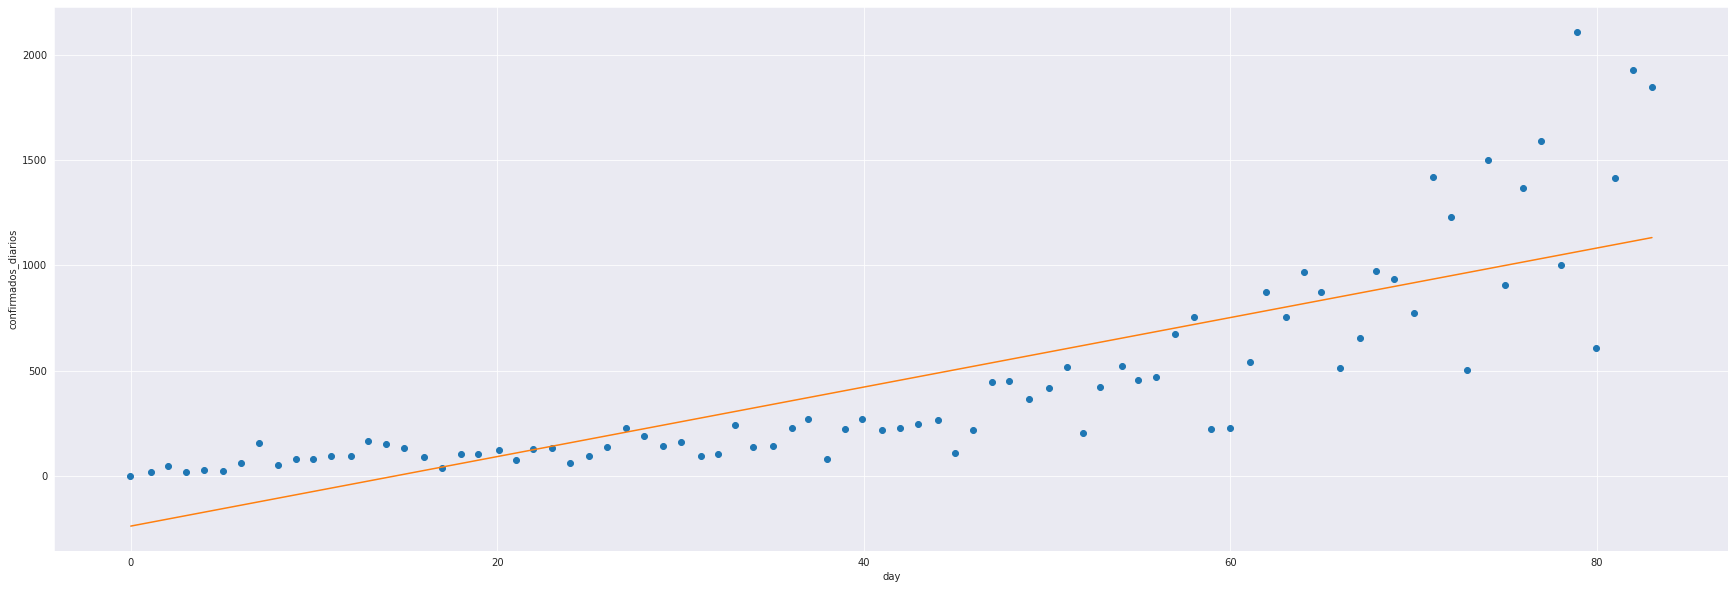

In [ ]:
from scipy.stats import linregress

xs = datos_arequipa['dia']
ys = datos_arequipa['confirmados_diarios']
res = linregress(xs, ys)

# Plot the scatter plot
plt.figure(figsize=(30,10))
plt.clf()
x_jitter = xs + np.random.normal(0, 0.05, len(xs))
plt.plot(x_jitter, ys, 'o')

# Plot the line of best fit
fx = np.array([xs.min(), xs.max()])
fy = res.intercept + res.slope * fx
plt.plot(fx, fy, '-')

plt.xlabel('day')
plt.ylabel('confirmados_diarios')
plt.show()

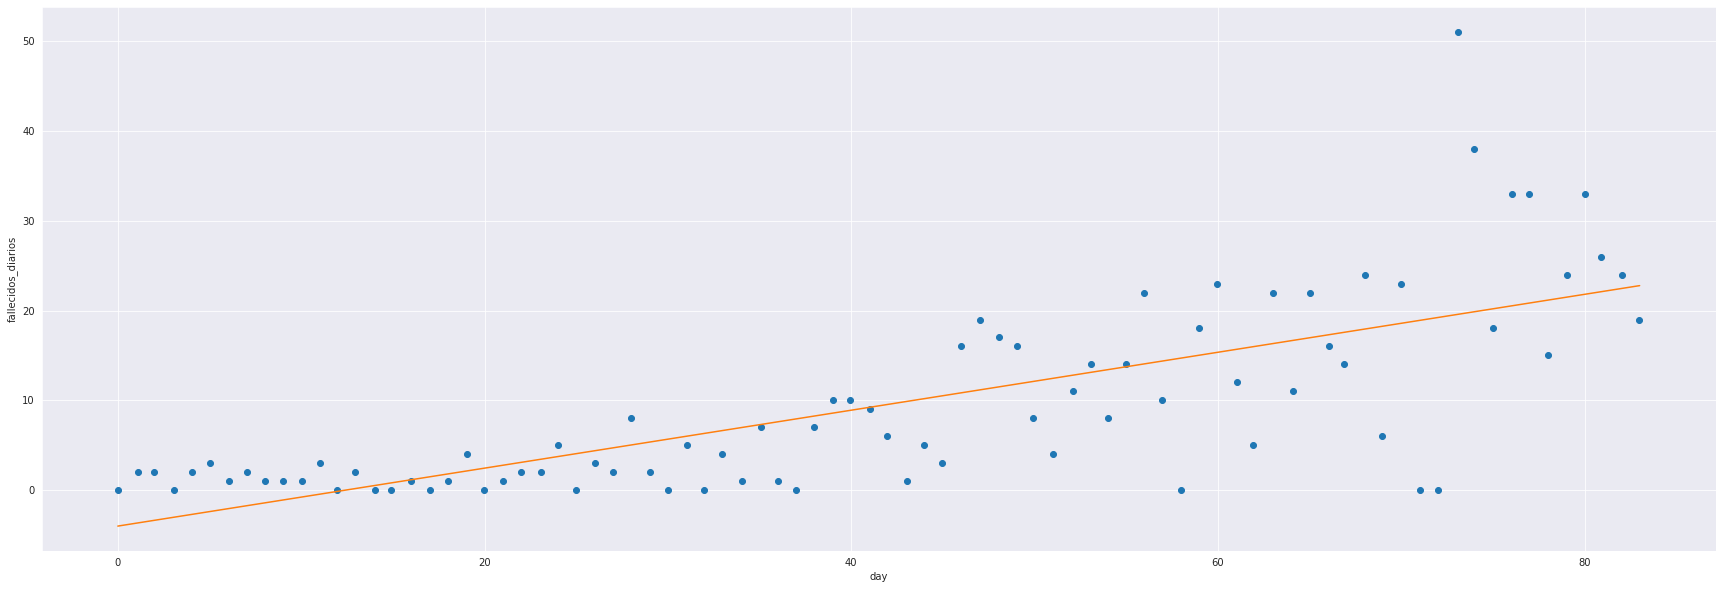

In [ ]:
from scipy.stats import linregress

xs = datos_arequipa['dia']
ys = datos_arequipa['fallecidos_diarios']
res = linregress(xs, ys)

# Plot the scatter plot
plt.figure(figsize=(30,10))
plt.clf()
x_jitter = xs + np.random.normal(0, 0.05, len(xs))
plt.plot(x_jitter, ys, 'o')

# Plot the line of best fit
fx = np.array([xs.min(), xs.max()])
fy = res.intercept + res.slope * fx
plt.plot(fx, fy, '-')

plt.xlabel('day')
plt.ylabel('fallecidos_diarios')
plt.show()

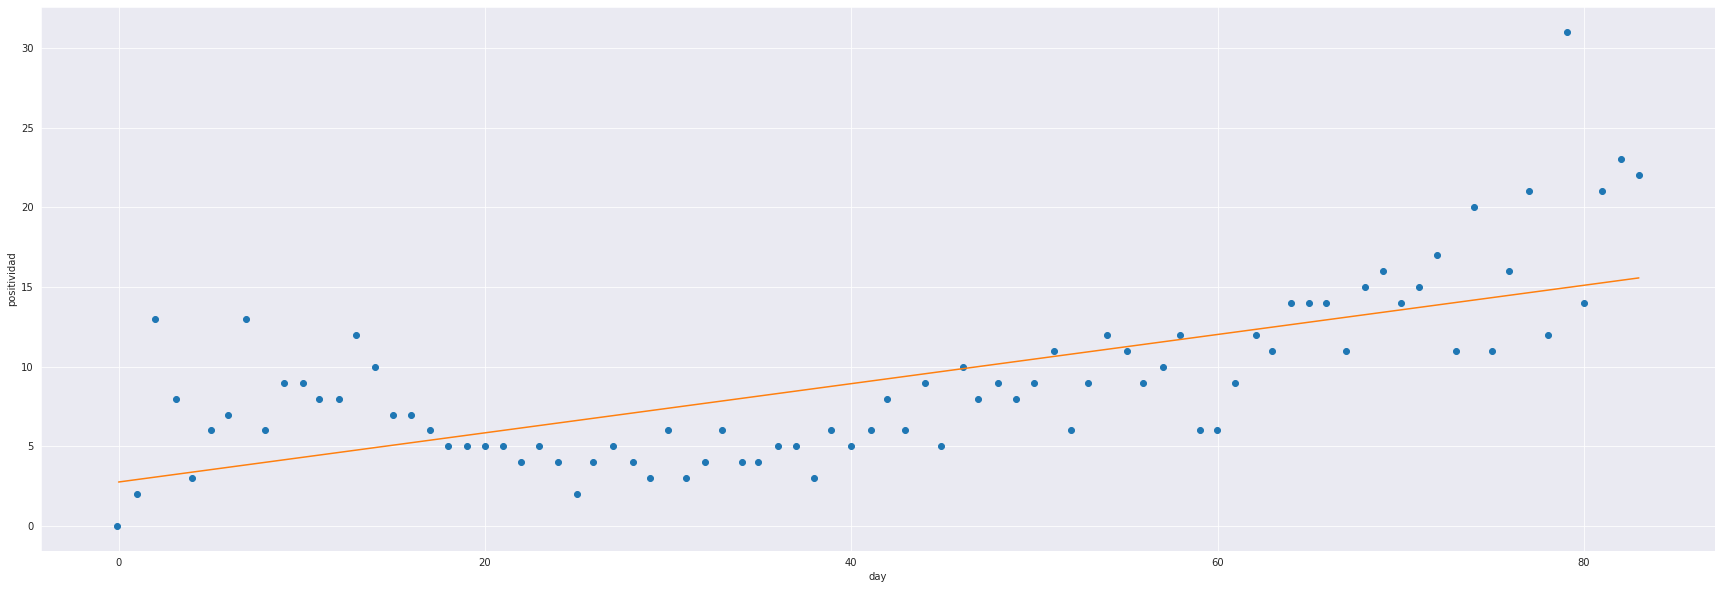

In [ ]:
from scipy.stats import linregress

xs = datos_arequipa['dia']
ys = datos_arequipa['positividad']
res = linregress(xs, ys)

# Plot the scatter plot
plt.figure(figsize=(30,10))
plt.clf()
x_jitter = xs + np.random.normal(0, 0.05, len(xs))
plt.plot(x_jitter, ys, 'o')

# Plot the line of best fit
fx = np.array([xs.min(), xs.max()])
fy = res.intercept + res.slope * fx
plt.plot(fx, fy, '-')

plt.xlabel('day')
plt.ylabel('positividad')
plt.show()

In [ ]:
import statsmodels.formula.api as smf

results = smf.ols('positividad ~ dia', data=datos_arequipa).fit()
results.params

Intercept    2.764986
dia          0.154257
dtype: float64

Cada dia la linea de regresion aumenta un 0.01

In [ ]:
datos_arequipa['dia2'] = datos_arequipa['dia'] ** 2
datos_arequipa['dia3'] = datos_arequipa['dia'] ** 3

model = smf.ols('positividad ~ dia + dia2 + dia3', data=datos_arequipa)

results = model.fit()
results.params

Intercept    7.471727
dia         -0.119481
dia2         0.000765
dia3         0.000034
dtype: float64

In [ ]:
df = pd.DataFrame()
df['dia'] = np.linspace(0, 90)
df['dia2'] = df['dia'] ** 2
df['dia3'] = df['dia'] ** 3

pred12 = results.predict(df)

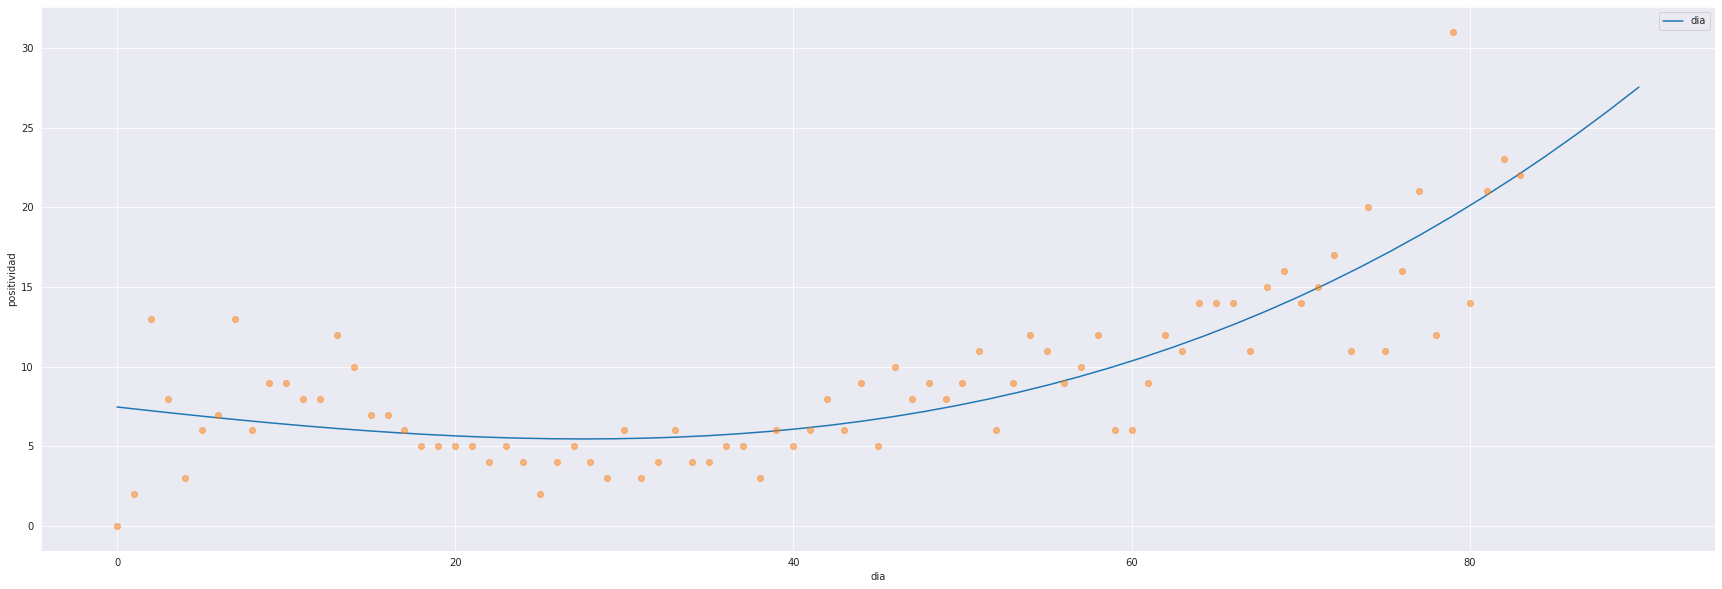

In [ ]:
plt.figure(figsize=(30,10))
plt.plot(df['dia'], pred12, label='dia')
plt.plot(datos_arequipa['dia'], datos_arequipa['positividad'], 'o', alpha=0.5)

plt.xlabel('dia')
plt.ylabel('positividad')
plt.legend()
plt.show()

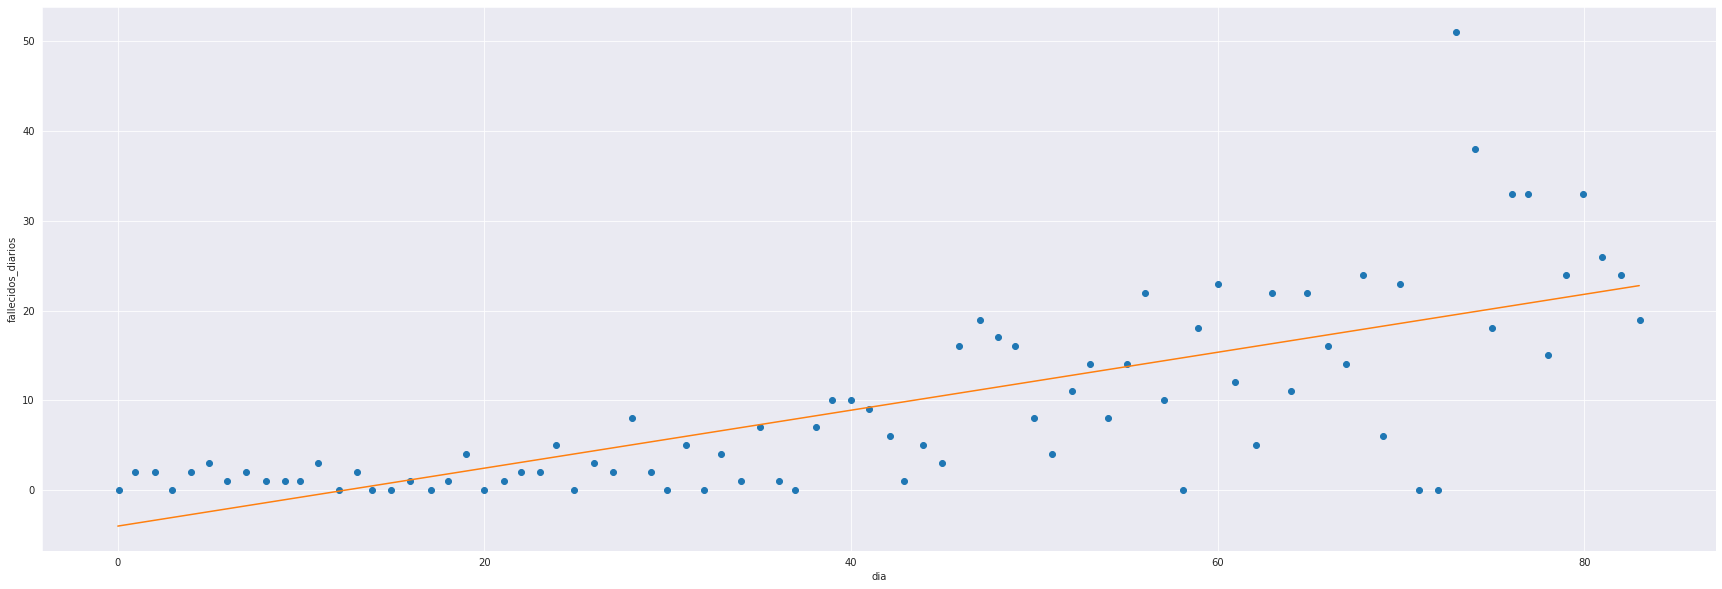

In [ ]:
from scipy.stats import linregress

xs = datos_arequipa['dia']
ys = datos_arequipa['fallecidos_diarios']
res = linregress(xs, ys)

# Plot the scatter plot
plt.figure(figsize=(30,10))
plt.clf()
x_jitter = xs + np.random.normal(0, 0.05, len(xs))
plt.plot(x_jitter, ys, 'o')

# Plot the line of best fit
fx = np.array([xs.min(), xs.max()])
fy = res.intercept + res.slope * fx
plt.plot(fx, fy, '-')

plt.xlabel('dia')
plt.ylabel('fallecidos_diarios')
plt.show()

In [ ]:
results = smf.ols('fallecidos_diarios ~ dia + positividad', data=datos_arequipa).fit()
results.params

Intercept     -4.710022
dia            0.281899
positividad    0.262261
dtype: float64

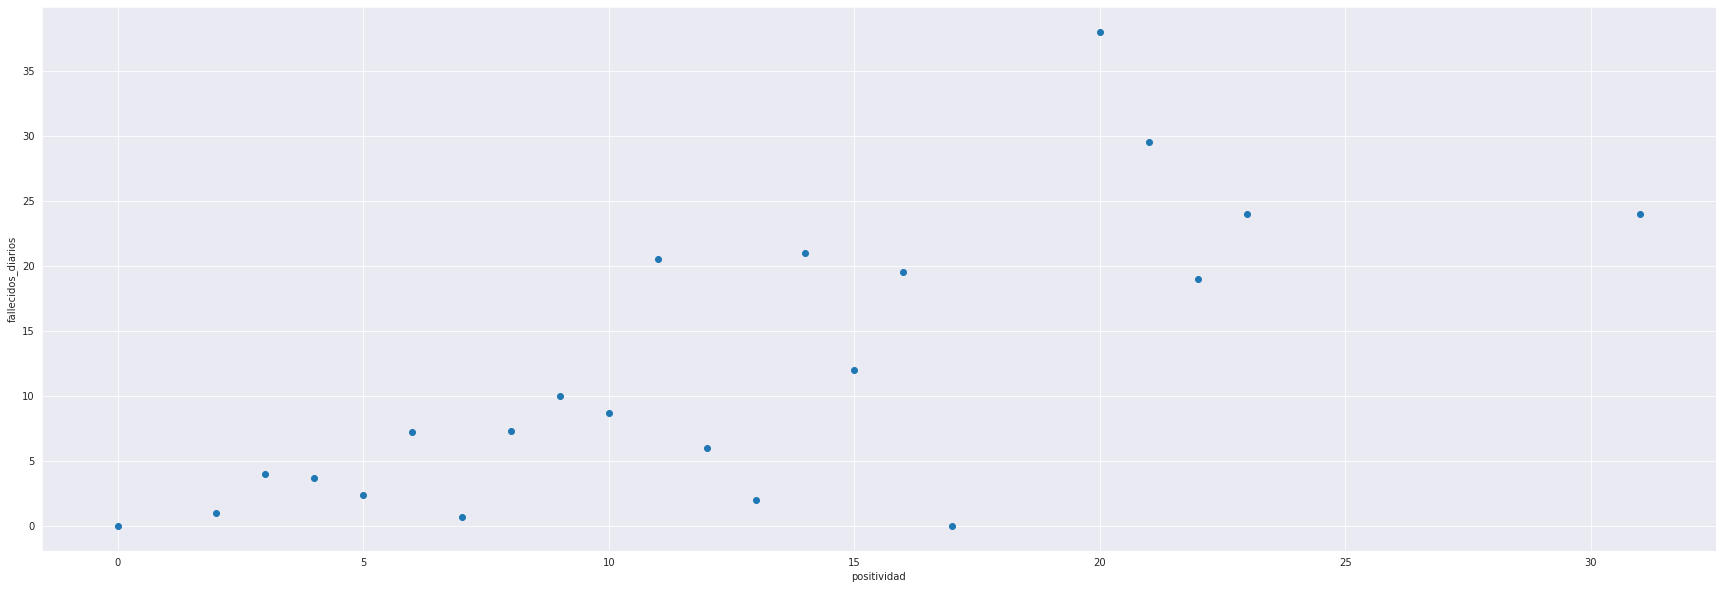

In [ ]:
#grouped = datos_arequipa.groupby('dia')
grouped = datos_arequipa.groupby('positividad')
mean_positividad_by_weekday = grouped['fallecidos_diarios'].mean()
plt.figure(figsize=(30,10))
plt.plot(mean_positividad_by_weekday, 'o')

plt.xlabel('positividad')
plt.ylabel('fallecidos_diarios')
plt.show()

In [ ]:
datos_arequipa['positividad2'] = datos_arequipa['positividad'] ** 2
datos_arequipa['dia2'] = datos_arequipa['dia'] ** 2

model = smf.ols('fallecidos_diarios ~ dia + dia2 + positividad + positividad2', data=datos_arequipa)
results = model.fit()
results.params

Intercept       2.736423
dia            -0.104302
dia2            0.005546
positividad    -0.178809
positividad2   -0.001655
dtype: float64

In [ ]:
df = pd.DataFrame()
df['positividad'] = np.linspace(0, 13)
df['positividad2'] = df['positividad'] ** 2

df['dia'] = np.linspace(0, 90)
df['dia2'] = df['dia'] ** 2

pred12 = results.predict(df)

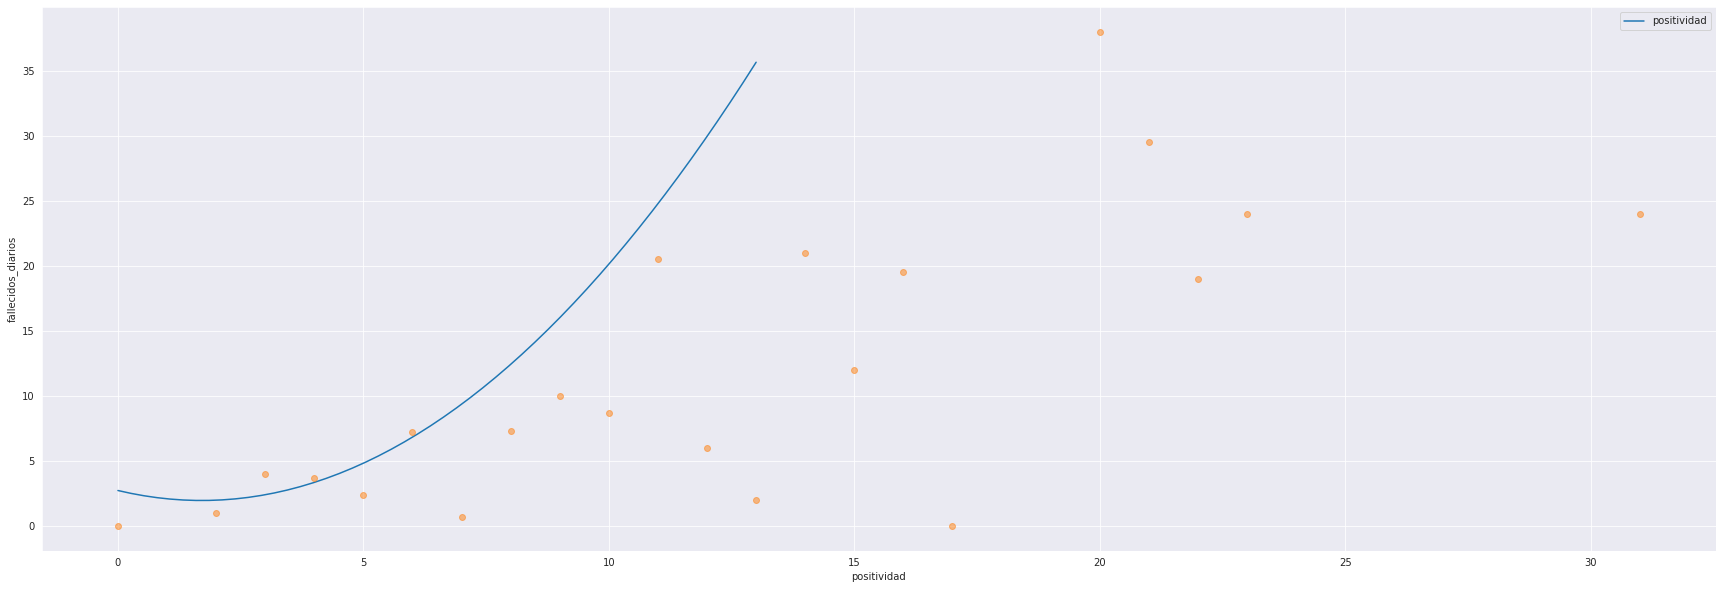

In [ ]:
#plt.plot(df['dia'], pred12, label='dia')
plt.figure(figsize=(30,10))
plt.plot(df['positividad'], pred12, label='positividad')
plt.plot(mean_positividad_by_weekday, 'o', alpha=0.5)

#plt.xlabel('dia')
plt.xlabel('positividad')
plt.ylabel('fallecidos_diarios')
plt.legend()
plt.show()